In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1t2','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_b25_t1_mask_t1t2_native_k5_b25_t1t2_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(3944610, 198)
(3944610, 8)
validation
(464344, 198)
(464344, 8)
test
(574820, 198)
(574820, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 198)]             0         


 dense (Dense)               (None, 1024)              203776    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 893832 (3.41 MB)


Trainable params: 893832 (3.41 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/395 [..............................] - ETA: 8:30 - loss: 2.4146 - STD: 0.0668 - MAE: 0.2212

  6/395 [..............................] - ETA: 3s - loss: 2.1584 - STD: 0.0522 - MAE: 0.2173  

 12/395 [..............................] - ETA: 3s - loss: 2.1208 - STD: 0.0544 - MAE: 0.2164

 18/395 [>.............................] - ETA: 3s - loss: 2.1012 - STD: 0.0436 - MAE: 0.2168

 23/395 [>.............................] - ETA: 3s - loss: 2.0924 - STD: 0.0414 - MAE: 0.2168

 29/395 [=>............................] - ETA: 3s - loss: 2.0841 - STD: 0.0404 - MAE: 0.2167

 35/395 [=>............................] - ETA: 3s - loss: 2.0793 - STD: 0.0396 - MAE: 0.2167

 40/395 [==>...........................] - ETA: 3s - loss: 2.0759 - STD: 0.0386 - MAE: 0.2167

 46/395 [==>...........................] - ETA: 3s - loss: 2.0728 - STD: 0.0375 - MAE: 0.2167

 52/395 [==>...........................] - ETA: 3s - loss: 2.0703 - STD: 0.0370 - MAE: 0.2167

 58/395 [===>..........................] - ETA: 3s - loss: 2.0684 - STD: 0.0366 - MAE: 0.2167

 64/395 [===>..........................] - ETA: 3s - loss: 2.0666 - STD: 0.0361 - MAE: 0.2167

 70/395 [====>.........................] - ETA: 3s - loss: 2.0652 - STD: 0.0359 - MAE: 0.2167

 76/395 [====>.........................] - ETA: 3s - loss: 2.0642 - STD: 0.0356 - MAE: 0.2167

 82/395 [=====>........................] - ETA: 3s - loss: 2.0632 - STD: 0.0352 - MAE: 0.2167

 88/395 [=====>........................] - ETA: 2s - loss: 2.0623 - STD: 0.0351 - MAE: 0.2167

 93/395 [======>.......................] - ETA: 5s - loss: 2.0616 - STD: 0.0349 - MAE: 0.2167

 99/395 [======>.......................] - ETA: 4s - loss: 2.0609 - STD: 0.0347 - MAE: 0.2167

104/395 [======>.......................] - ETA: 4s - loss: 2.0602 - STD: 0.0345 - MAE: 0.2167

110/395 [=======>......................] - ETA: 4s - loss: 2.0592 - STD: 0.0343 - MAE: 0.2167

116/395 [=======>......................] - ETA: 4s - loss: 2.0575 - STD: 0.0342 - MAE: 0.2166

122/395 [========>.....................] - ETA: 4s - loss: 2.0553 - STD: 0.0344 - MAE: 0.2165

128/395 [========>.....................] - ETA: 4s - loss: 2.0521 - STD: 0.0347 - MAE: 0.2164

134/395 [=========>....................] - ETA: 3s - loss: 2.0481 - STD: 0.0354 - MAE: 0.2162

140/395 [=========>....................] - ETA: 3s - loss: 2.0432 - STD: 0.0364 - MAE: 0.2160

146/395 [==========>...................] - ETA: 3s - loss: 2.0379 - STD: 0.0377 - MAE: 0.2157

152/395 [==========>...................] - ETA: 3s - loss: 2.0324 - STD: 0.0390 - MAE: 0.2154

158/395 [===========>..................] - ETA: 3s - loss: 2.0271 - STD: 0.0404 - MAE: 0.2151

164/395 [===========>..................] - ETA: 3s - loss: 2.0219 - STD: 0.0416 - MAE: 0.2148

170/395 [===========>..................] - ETA: 3s - loss: 2.0167 - STD: 0.0428 - MAE: 0.2145

176/395 [============>.................] - ETA: 3s - loss: 2.0116 - STD: 0.0440 - MAE: 0.2142

182/395 [============>.................] - ETA: 2s - loss: 2.0062 - STD: 0.0452 - MAE: 0.2139

187/395 [=============>................] - ETA: 2s - loss: 2.0018 - STD: 0.0461 - MAE: 0.2136

193/395 [=============>................] - ETA: 2s - loss: 1.9964 - STD: 0.0472 - MAE: 0.2133

199/395 [==============>...............] - ETA: 2s - loss: 1.9910 - STD: 0.0484 - MAE: 0.2130

205/395 [==============>...............] - ETA: 2s - loss: 1.9856 - STD: 0.0496 - MAE: 0.2127

211/395 [===============>..............] - ETA: 2s - loss: 1.9805 - STD: 0.0507 - MAE: 0.2123

217/395 [===============>..............] - ETA: 2s - loss: 1.9754 - STD: 0.0518 - MAE: 0.2120

223/395 [===============>..............] - ETA: 2s - loss: 1.9703 - STD: 0.0529 - MAE: 0.2117

229/395 [================>.............] - ETA: 2s - loss: 1.9653 - STD: 0.0541 - MAE: 0.2114

234/395 [================>.............] - ETA: 2s - loss: 1.9615 - STD: 0.0550 - MAE: 0.2111

240/395 [=================>............] - ETA: 1s - loss: 1.9566 - STD: 0.0560 - MAE: 0.2108

246/395 [=================>............] - ETA: 1s - loss: 1.9520 - STD: 0.0571 - MAE: 0.2105

252/395 [==================>...........] - ETA: 1s - loss: 1.9476 - STD: 0.0581 - MAE: 0.2102

258/395 [==================>...........] - ETA: 1s - loss: 1.9431 - STD: 0.0591 - MAE: 0.2099

263/395 [==================>...........] - ETA: 1s - loss: 1.9395 - STD: 0.0599 - MAE: 0.2097

268/395 [===================>..........] - ETA: 1s - loss: 1.9360 - STD: 0.0607 - MAE: 0.2094

274/395 [===================>..........] - ETA: 1s - loss: 1.9319 - STD: 0.0616 - MAE: 0.2092

280/395 [====================>.........] - ETA: 1s - loss: 1.9279 - STD: 0.0624 - MAE: 0.2089

286/395 [====================>.........] - ETA: 1s - loss: 1.9237 - STD: 0.0633 - MAE: 0.2086

291/395 [=====================>........] - ETA: 1s - loss: 1.9203 - STD: 0.0640 - MAE: 0.2084

297/395 [=====================>........] - ETA: 1s - loss: 1.9165 - STD: 0.0649 - MAE: 0.2081

303/395 [======================>.......] - ETA: 1s - loss: 1.9127 - STD: 0.0657 - MAE: 0.2079

309/395 [======================>.......] - ETA: 1s - loss: 1.9089 - STD: 0.0665 - MAE: 0.2076

315/395 [======================>.......] - ETA: 0s - loss: 1.9051 - STD: 0.0673 - MAE: 0.2074

321/395 [=======================>......] - ETA: 0s - loss: 1.9014 - STD: 0.0681 - MAE: 0.2071

327/395 [=======================>......] - ETA: 0s - loss: 1.8978 - STD: 0.0689 - MAE: 0.2069

333/395 [========================>.....] - ETA: 0s - loss: 1.8942 - STD: 0.0696 - MAE: 0.2067

339/395 [========================>.....] - ETA: 0s - loss: 1.8906 - STD: 0.0704 - MAE: 0.2064

345/395 [=========================>....] - ETA: 0s - loss: 1.8872 - STD: 0.0711 - MAE: 0.2062

350/395 [=========================>....] - ETA: 0s - loss: 1.8843 - STD: 0.0717 - MAE: 0.2060

356/395 [==========================>...] - ETA: 0s - loss: 1.8811 - STD: 0.0724 - MAE: 0.2058

362/395 [==========================>...] - ETA: 0s - loss: 1.8779 - STD: 0.0731 - MAE: 0.2056

368/395 [==========================>...] - ETA: 0s - loss: 1.8747 - STD: 0.0737 - MAE: 0.2053

374/395 [===========================>..] - ETA: 0s - loss: 1.8716 - STD: 0.0744 - MAE: 0.2051

380/395 [===========================>..] - ETA: 0s - loss: 1.8687 - STD: 0.0750 - MAE: 0.2049

386/395 [============================>.] - ETA: 0s - loss: 1.8657 - STD: 0.0756 - MAE: 0.2047

392/395 [============================>.] - ETA: 0s - loss: 1.8628 - STD: 0.0762 - MAE: 0.2045

395/395 [==============================] - 7s 14ms/step - loss: 1.8614 - STD: 0.0765 - MAE: 0.2044 - val_loss: 1.6452 - val_STD: 0.1123 - val_MAE: 0.1901


Epoch 2/10000


  1/395 [..............................] - ETA: 12s - loss: 1.6829 - STD: 0.1172 - MAE: 0.1916

  6/395 [..............................] - ETA: 3s - loss: 1.6821 - STD: 0.1144 - MAE: 0.1920 

 12/395 [..............................] - ETA: 3s - loss: 1.6829 - STD: 0.1151 - MAE: 0.1919

 18/395 [>.............................] - ETA: 3s - loss: 1.6813 - STD: 0.1154 - MAE: 0.1917

 24/395 [>.............................] - ETA: 3s - loss: 1.6798 - STD: 0.1156 - MAE: 0.1916

 30/395 [=>............................] - ETA: 3s - loss: 1.6791 - STD: 0.1155 - MAE: 0.1916

 36/395 [=>............................] - ETA: 3s - loss: 1.6778 - STD: 0.1155 - MAE: 0.1916

 42/395 [==>...........................] - ETA: 3s - loss: 1.6766 - STD: 0.1157 - MAE: 0.1915

 48/395 [==>...........................] - ETA: 3s - loss: 1.6752 - STD: 0.1158 - MAE: 0.1915

 54/395 [===>..........................] - ETA: 3s - loss: 1.6738 - STD: 0.1159 - MAE: 0.1914

 59/395 [===>..........................] - ETA: 3s - loss: 1.6730 - STD: 0.1160 - MAE: 0.1913

 65/395 [===>..........................] - ETA: 3s - loss: 1.6716 - STD: 0.1161 - MAE: 0.1913

 71/395 [====>.........................] - ETA: 3s - loss: 1.6708 - STD: 0.1162 - MAE: 0.1912

 77/395 [====>.........................] - ETA: 3s - loss: 1.6702 - STD: 0.1164 - MAE: 0.1911

 83/395 [=====>........................] - ETA: 3s - loss: 1.6694 - STD: 0.1165 - MAE: 0.1911

 89/395 [=====>........................] - ETA: 2s - loss: 1.6685 - STD: 0.1166 - MAE: 0.1910

 95/395 [======>.......................] - ETA: 2s - loss: 1.6676 - STD: 0.1167 - MAE: 0.1910

101/395 [======>.......................] - ETA: 2s - loss: 1.6671 - STD: 0.1168 - MAE: 0.1909

107/395 [=======>......................] - ETA: 2s - loss: 1.6667 - STD: 0.1169 - MAE: 0.1909

113/395 [=======>......................] - ETA: 2s - loss: 1.6662 - STD: 0.1171 - MAE: 0.1908

119/395 [========>.....................] - ETA: 2s - loss: 1.6660 - STD: 0.1172 - MAE: 0.1908

125/395 [========>.....................] - ETA: 2s - loss: 1.6657 - STD: 0.1173 - MAE: 0.1907

131/395 [========>.....................] - ETA: 2s - loss: 1.6653 - STD: 0.1173 - MAE: 0.1907

137/395 [=========>....................] - ETA: 2s - loss: 1.6650 - STD: 0.1174 - MAE: 0.1907

143/395 [=========>....................] - ETA: 2s - loss: 1.6647 - STD: 0.1175 - MAE: 0.1906

149/395 [==========>...................] - ETA: 2s - loss: 1.6644 - STD: 0.1176 - MAE: 0.1906

155/395 [==========>...................] - ETA: 2s - loss: 1.6638 - STD: 0.1176 - MAE: 0.1906

161/395 [===========>..................] - ETA: 2s - loss: 1.6632 - STD: 0.1177 - MAE: 0.1905

167/395 [===========>..................] - ETA: 2s - loss: 1.6625 - STD: 0.1178 - MAE: 0.1905

173/395 [============>.................] - ETA: 2s - loss: 1.6619 - STD: 0.1179 - MAE: 0.1904

179/395 [============>.................] - ETA: 2s - loss: 1.6613 - STD: 0.1180 - MAE: 0.1904

185/395 [=============>................] - ETA: 2s - loss: 1.6608 - STD: 0.1181 - MAE: 0.1903

191/395 [=============>................] - ETA: 1s - loss: 1.6602 - STD: 0.1182 - MAE: 0.1903

197/395 [=============>................] - ETA: 1s - loss: 1.6597 - STD: 0.1183 - MAE: 0.1903

203/395 [==============>...............] - ETA: 1s - loss: 1.6592 - STD: 0.1184 - MAE: 0.1902

209/395 [==============>...............] - ETA: 1s - loss: 1.6587 - STD: 0.1185 - MAE: 0.1902

215/395 [===============>..............] - ETA: 1s - loss: 1.6582 - STD: 0.1185 - MAE: 0.1901

221/395 [===============>..............] - ETA: 1s - loss: 1.6574 - STD: 0.1187 - MAE: 0.1901

226/395 [================>.............] - ETA: 1s - loss: 1.6570 - STD: 0.1187 - MAE: 0.1901

231/395 [================>.............] - ETA: 1s - loss: 1.6566 - STD: 0.1188 - MAE: 0.1900

237/395 [=================>............] - ETA: 1s - loss: 1.6561 - STD: 0.1189 - MAE: 0.1900

242/395 [=================>............] - ETA: 1s - loss: 1.6557 - STD: 0.1190 - MAE: 0.1899

248/395 [=================>............] - ETA: 1s - loss: 1.6554 - STD: 0.1191 - MAE: 0.1899

254/395 [==================>...........] - ETA: 1s - loss: 1.6552 - STD: 0.1192 - MAE: 0.1899

260/395 [==================>...........] - ETA: 1s - loss: 1.6547 - STD: 0.1192 - MAE: 0.1898

266/395 [===================>..........] - ETA: 1s - loss: 1.6543 - STD: 0.1193 - MAE: 0.1898

272/395 [===================>..........] - ETA: 1s - loss: 1.6536 - STD: 0.1194 - MAE: 0.1898

278/395 [====================>.........] - ETA: 1s - loss: 1.6531 - STD: 0.1195 - MAE: 0.1897

284/395 [====================>.........] - ETA: 1s - loss: 1.6527 - STD: 0.1195 - MAE: 0.1897

290/395 [=====================>........] - ETA: 1s - loss: 1.6523 - STD: 0.1196 - MAE: 0.1897

296/395 [=====================>........] - ETA: 0s - loss: 1.6519 - STD: 0.1197 - MAE: 0.1896

302/395 [=====================>........] - ETA: 0s - loss: 1.6514 - STD: 0.1197 - MAE: 0.1896

307/395 [======================>.......] - ETA: 0s - loss: 1.6511 - STD: 0.1198 - MAE: 0.1896

313/395 [======================>.......] - ETA: 0s - loss: 1.6506 - STD: 0.1199 - MAE: 0.1895

318/395 [=======================>......] - ETA: 0s - loss: 1.6503 - STD: 0.1199 - MAE: 0.1895

323/395 [=======================>......] - ETA: 0s - loss: 1.6500 - STD: 0.1200 - MAE: 0.1895

329/395 [=======================>......] - ETA: 0s - loss: 1.6496 - STD: 0.1201 - MAE: 0.1894

335/395 [========================>.....] - ETA: 0s - loss: 1.6491 - STD: 0.1201 - MAE: 0.1894

341/395 [========================>.....] - ETA: 0s - loss: 1.6487 - STD: 0.1202 - MAE: 0.1894

347/395 [=========================>....] - ETA: 0s - loss: 1.6483 - STD: 0.1203 - MAE: 0.1893

353/395 [=========================>....] - ETA: 0s - loss: 1.6479 - STD: 0.1204 - MAE: 0.1893

359/395 [==========================>...] - ETA: 0s - loss: 1.6477 - STD: 0.1204 - MAE: 0.1893

365/395 [==========================>...] - ETA: 0s - loss: 1.6472 - STD: 0.1205 - MAE: 0.1893

371/395 [===========================>..] - ETA: 0s - loss: 1.6469 - STD: 0.1206 - MAE: 0.1892

377/395 [===========================>..] - ETA: 0s - loss: 1.6467 - STD: 0.1207 - MAE: 0.1892

383/395 [============================>.] - ETA: 0s - loss: 1.6465 - STD: 0.1207 - MAE: 0.1892

389/395 [============================>.] - ETA: 0s - loss: 1.6462 - STD: 0.1208 - MAE: 0.1892

395/395 [==============================] - ETA: 0s - loss: 1.6460 - STD: 0.1208 - MAE: 0.1891

395/395 [==============================] - 4s 10ms/step - loss: 1.6460 - STD: 0.1208 - MAE: 0.1891 - val_loss: 1.6553 - val_STD: 0.1209 - val_MAE: 0.1880


Epoch 3/10000


  1/395 [..............................] - ETA: 13s - loss: 1.6407 - STD: 0.1254 - MAE: 0.1879

  7/395 [..............................] - ETA: 3s - loss: 1.6256 - STD: 0.1247 - MAE: 0.1874 

 13/395 [..............................] - ETA: 3s - loss: 1.6292 - STD: 0.1249 - MAE: 0.1875

 19/395 [>.............................] - ETA: 3s - loss: 1.6280 - STD: 0.1245 - MAE: 0.1875

 25/395 [>.............................] - ETA: 3s - loss: 1.6265 - STD: 0.1245 - MAE: 0.1875

 31/395 [=>............................] - ETA: 3s - loss: 1.6254 - STD: 0.1246 - MAE: 0.1874

 37/395 [=>............................] - ETA: 3s - loss: 1.6244 - STD: 0.1247 - MAE: 0.1873

 42/395 [==>...........................] - ETA: 3s - loss: 1.6231 - STD: 0.1246 - MAE: 0.1873

 48/395 [==>...........................] - ETA: 3s - loss: 1.6230 - STD: 0.1247 - MAE: 0.1873

 54/395 [===>..........................] - ETA: 3s - loss: 1.6226 - STD: 0.1248 - MAE: 0.1873

 60/395 [===>..........................] - ETA: 3s - loss: 1.6218 - STD: 0.1249 - MAE: 0.1872

 66/395 [====>.........................] - ETA: 3s - loss: 1.6213 - STD: 0.1249 - MAE: 0.1872

 71/395 [====>.........................] - ETA: 3s - loss: 1.6209 - STD: 0.1251 - MAE: 0.1871

 76/395 [====>.........................] - ETA: 3s - loss: 1.6207 - STD: 0.1251 - MAE: 0.1871

 81/395 [=====>........................] - ETA: 3s - loss: 1.6199 - STD: 0.1251 - MAE: 0.1871

 87/395 [=====>........................] - ETA: 3s - loss: 1.6192 - STD: 0.1252 - MAE: 0.1870

 93/395 [======>.......................] - ETA: 2s - loss: 1.6189 - STD: 0.1253 - MAE: 0.1870

 99/395 [======>.......................] - ETA: 2s - loss: 1.6184 - STD: 0.1254 - MAE: 0.1870

105/395 [======>.......................] - ETA: 2s - loss: 1.6181 - STD: 0.1254 - MAE: 0.1869

111/395 [=======>......................] - ETA: 2s - loss: 1.6174 - STD: 0.1255 - MAE: 0.1869

117/395 [=======>......................] - ETA: 2s - loss: 1.6171 - STD: 0.1256 - MAE: 0.1868

123/395 [========>.....................] - ETA: 2s - loss: 1.6168 - STD: 0.1256 - MAE: 0.1868

129/395 [========>.....................] - ETA: 2s - loss: 1.6163 - STD: 0.1257 - MAE: 0.1868

135/395 [=========>....................] - ETA: 2s - loss: 1.6161 - STD: 0.1257 - MAE: 0.1868

140/395 [=========>....................] - ETA: 2s - loss: 1.6159 - STD: 0.1257 - MAE: 0.1868

145/395 [==========>...................] - ETA: 2s - loss: 1.6158 - STD: 0.1257 - MAE: 0.1868

150/395 [==========>...................] - ETA: 2s - loss: 1.6158 - STD: 0.1258 - MAE: 0.1868

155/395 [==========>...................] - ETA: 2s - loss: 1.6157 - STD: 0.1258 - MAE: 0.1867

161/395 [===========>..................] - ETA: 2s - loss: 1.6153 - STD: 0.1258 - MAE: 0.1867

167/395 [===========>..................] - ETA: 2s - loss: 1.6151 - STD: 0.1259 - MAE: 0.1867

173/395 [============>.................] - ETA: 2s - loss: 1.6148 - STD: 0.1259 - MAE: 0.1867

178/395 [============>.................] - ETA: 2s - loss: 1.6147 - STD: 0.1260 - MAE: 0.1867

184/395 [============>.................] - ETA: 2s - loss: 1.6143 - STD: 0.1260 - MAE: 0.1866

190/395 [=============>................] - ETA: 2s - loss: 1.6142 - STD: 0.1261 - MAE: 0.1866

196/395 [=============>................] - ETA: 1s - loss: 1.6140 - STD: 0.1261 - MAE: 0.1866

202/395 [==============>...............] - ETA: 1s - loss: 1.6136 - STD: 0.1262 - MAE: 0.1866

207/395 [==============>...............] - ETA: 1s - loss: 1.6135 - STD: 0.1262 - MAE: 0.1866

212/395 [===============>..............] - ETA: 1s - loss: 1.6131 - STD: 0.1262 - MAE: 0.1865

217/395 [===============>..............] - ETA: 1s - loss: 1.6130 - STD: 0.1263 - MAE: 0.1865

223/395 [===============>..............] - ETA: 1s - loss: 1.6126 - STD: 0.1263 - MAE: 0.1865

229/395 [================>.............] - ETA: 1s - loss: 1.6122 - STD: 0.1264 - MAE: 0.1865

235/395 [================>.............] - ETA: 1s - loss: 1.6120 - STD: 0.1264 - MAE: 0.1865

241/395 [=================>............] - ETA: 1s - loss: 1.6118 - STD: 0.1264 - MAE: 0.1864

247/395 [=================>............] - ETA: 1s - loss: 1.6116 - STD: 0.1264 - MAE: 0.1864

252/395 [==================>...........] - ETA: 1s - loss: 1.6113 - STD: 0.1265 - MAE: 0.1864

258/395 [==================>...........] - ETA: 1s - loss: 1.6111 - STD: 0.1265 - MAE: 0.1864

264/395 [===================>..........] - ETA: 1s - loss: 1.6110 - STD: 0.1265 - MAE: 0.1864

270/395 [===================>..........] - ETA: 1s - loss: 1.6106 - STD: 0.1266 - MAE: 0.1864

276/395 [===================>..........] - ETA: 1s - loss: 1.6105 - STD: 0.1266 - MAE: 0.1863

281/395 [====================>.........] - ETA: 1s - loss: 1.6102 - STD: 0.1267 - MAE: 0.1863

287/395 [====================>.........] - ETA: 1s - loss: 1.6099 - STD: 0.1267 - MAE: 0.1863

293/395 [=====================>........] - ETA: 1s - loss: 1.6096 - STD: 0.1267 - MAE: 0.1863

299/395 [=====================>........] - ETA: 0s - loss: 1.6094 - STD: 0.1268 - MAE: 0.1863

304/395 [======================>.......] - ETA: 0s - loss: 1.6092 - STD: 0.1268 - MAE: 0.1862

310/395 [======================>.......] - ETA: 0s - loss: 1.6089 - STD: 0.1269 - MAE: 0.1862

316/395 [=======================>......] - ETA: 0s - loss: 1.6086 - STD: 0.1269 - MAE: 0.1862

322/395 [=======================>......] - ETA: 0s - loss: 1.6083 - STD: 0.1269 - MAE: 0.1862

327/395 [=======================>......] - ETA: 0s - loss: 1.6082 - STD: 0.1270 - MAE: 0.1862

333/395 [========================>.....] - ETA: 0s - loss: 1.6081 - STD: 0.1270 - MAE: 0.1861

338/395 [========================>.....] - ETA: 0s - loss: 1.6080 - STD: 0.1270 - MAE: 0.1861

344/395 [=========================>....] - ETA: 0s - loss: 1.6078 - STD: 0.1271 - MAE: 0.1861

350/395 [=========================>....] - ETA: 0s - loss: 1.6077 - STD: 0.1271 - MAE: 0.1861

356/395 [==========================>...] - ETA: 0s - loss: 1.6074 - STD: 0.1271 - MAE: 0.1861

362/395 [==========================>...] - ETA: 0s - loss: 1.6072 - STD: 0.1272 - MAE: 0.1861

368/395 [==========================>...] - ETA: 0s - loss: 1.6070 - STD: 0.1272 - MAE: 0.1861

373/395 [===========================>..] - ETA: 0s - loss: 1.6069 - STD: 0.1272 - MAE: 0.1860

379/395 [===========================>..] - ETA: 0s - loss: 1.6067 - STD: 0.1272 - MAE: 0.1860

384/395 [============================>.] - ETA: 0s - loss: 1.6065 - STD: 0.1273 - MAE: 0.1860

390/395 [============================>.] - ETA: 0s - loss: 1.6062 - STD: 0.1273 - MAE: 0.1860

395/395 [==============================] - 4s 11ms/step - loss: 1.6060 - STD: 0.1273 - MAE: 0.1860 - val_loss: 1.6217 - val_STD: 0.1238 - val_MAE: 0.1858


Epoch 4/10000


  1/395 [..............................] - ETA: 12s - loss: 1.5938 - STD: 0.1285 - MAE: 0.1852

  7/395 [..............................] - ETA: 3s - loss: 1.5898 - STD: 0.1300 - MAE: 0.1846 

 13/395 [..............................] - ETA: 3s - loss: 1.5857 - STD: 0.1303 - MAE: 0.1844

 19/395 [>.............................] - ETA: 3s - loss: 1.5853 - STD: 0.1302 - MAE: 0.1844

 25/395 [>.............................] - ETA: 3s - loss: 1.5860 - STD: 0.1303 - MAE: 0.1844

 31/395 [=>............................] - ETA: 3s - loss: 1.5864 - STD: 0.1301 - MAE: 0.1845

 37/395 [=>............................] - ETA: 3s - loss: 1.5866 - STD: 0.1302 - MAE: 0.1845

 43/395 [==>...........................] - ETA: 3s - loss: 1.5872 - STD: 0.1302 - MAE: 0.1845

 49/395 [==>...........................] - ETA: 3s - loss: 1.5866 - STD: 0.1302 - MAE: 0.1845

 55/395 [===>..........................] - ETA: 3s - loss: 1.5864 - STD: 0.1302 - MAE: 0.1844

 60/395 [===>..........................] - ETA: 3s - loss: 1.5863 - STD: 0.1302 - MAE: 0.1844

 66/395 [====>.........................] - ETA: 3s - loss: 1.5867 - STD: 0.1302 - MAE: 0.1844

 72/395 [====>.........................] - ETA: 3s - loss: 1.5873 - STD: 0.1303 - MAE: 0.1845

 78/395 [====>.........................] - ETA: 3s - loss: 1.5880 - STD: 0.1303 - MAE: 0.1845

 84/395 [=====>........................] - ETA: 3s - loss: 1.5883 - STD: 0.1303 - MAE: 0.1845

 90/395 [=====>........................] - ETA: 2s - loss: 1.5880 - STD: 0.1303 - MAE: 0.1845

 95/395 [======>.......................] - ETA: 2s - loss: 1.5879 - STD: 0.1303 - MAE: 0.1845

101/395 [======>.......................] - ETA: 2s - loss: 1.5879 - STD: 0.1302 - MAE: 0.1845

107/395 [=======>......................] - ETA: 2s - loss: 1.5875 - STD: 0.1302 - MAE: 0.1845

113/395 [=======>......................] - ETA: 2s - loss: 1.5869 - STD: 0.1303 - MAE: 0.1844

118/395 [=======>......................] - ETA: 2s - loss: 1.5869 - STD: 0.1304 - MAE: 0.1844

124/395 [========>.....................] - ETA: 2s - loss: 1.5868 - STD: 0.1304 - MAE: 0.1844

130/395 [========>.....................] - ETA: 2s - loss: 1.5868 - STD: 0.1304 - MAE: 0.1844

136/395 [=========>....................] - ETA: 2s - loss: 1.5867 - STD: 0.1305 - MAE: 0.1844

142/395 [=========>....................] - ETA: 2s - loss: 1.5868 - STD: 0.1304 - MAE: 0.1844

148/395 [==========>...................] - ETA: 2s - loss: 1.5868 - STD: 0.1304 - MAE: 0.1844

154/395 [==========>...................] - ETA: 2s - loss: 1.5867 - STD: 0.1305 - MAE: 0.1844

160/395 [===========>..................] - ETA: 2s - loss: 1.5864 - STD: 0.1305 - MAE: 0.1844

166/395 [===========>..................] - ETA: 2s - loss: 1.5863 - STD: 0.1305 - MAE: 0.1844

172/395 [============>.................] - ETA: 2s - loss: 1.5858 - STD: 0.1305 - MAE: 0.1843

178/395 [============>.................] - ETA: 2s - loss: 1.5856 - STD: 0.1306 - MAE: 0.1843

184/395 [============>.................] - ETA: 2s - loss: 1.5851 - STD: 0.1306 - MAE: 0.1843

189/395 [=============>................] - ETA: 2s - loss: 1.5849 - STD: 0.1306 - MAE: 0.1843

195/395 [=============>................] - ETA: 1s - loss: 1.5846 - STD: 0.1306 - MAE: 0.1843

201/395 [==============>...............] - ETA: 1s - loss: 1.5842 - STD: 0.1307 - MAE: 0.1842

207/395 [==============>...............] - ETA: 1s - loss: 1.5838 - STD: 0.1307 - MAE: 0.1842

213/395 [===============>..............] - ETA: 1s - loss: 1.5834 - STD: 0.1308 - MAE: 0.1842

219/395 [===============>..............] - ETA: 1s - loss: 1.5830 - STD: 0.1308 - MAE: 0.1841

224/395 [================>.............] - ETA: 1s - loss: 1.5827 - STD: 0.1309 - MAE: 0.1841

230/395 [================>.............] - ETA: 1s - loss: 1.5826 - STD: 0.1309 - MAE: 0.1841

236/395 [================>.............] - ETA: 1s - loss: 1.5820 - STD: 0.1310 - MAE: 0.1841

242/395 [=================>............] - ETA: 1s - loss: 1.5818 - STD: 0.1310 - MAE: 0.1840

247/395 [=================>............] - ETA: 1s - loss: 1.5815 - STD: 0.1310 - MAE: 0.1840

252/395 [==================>...........] - ETA: 1s - loss: 1.5814 - STD: 0.1311 - MAE: 0.1840

258/395 [==================>...........] - ETA: 1s - loss: 1.5812 - STD: 0.1311 - MAE: 0.1840

264/395 [===================>..........] - ETA: 1s - loss: 1.5808 - STD: 0.1311 - MAE: 0.1840

269/395 [===================>..........] - ETA: 1s - loss: 1.5806 - STD: 0.1312 - MAE: 0.1840

275/395 [===================>..........] - ETA: 1s - loss: 1.5804 - STD: 0.1312 - MAE: 0.1839

281/395 [====================>.........] - ETA: 1s - loss: 1.5802 - STD: 0.1312 - MAE: 0.1839

286/395 [====================>.........] - ETA: 1s - loss: 1.5799 - STD: 0.1313 - MAE: 0.1839

292/395 [=====================>........] - ETA: 1s - loss: 1.5796 - STD: 0.1313 - MAE: 0.1839

298/395 [=====================>........] - ETA: 0s - loss: 1.5794 - STD: 0.1313 - MAE: 0.1838

304/395 [======================>.......] - ETA: 0s - loss: 1.5790 - STD: 0.1314 - MAE: 0.1838

310/395 [======================>.......] - ETA: 0s - loss: 1.5787 - STD: 0.1314 - MAE: 0.1838

316/395 [=======================>......] - ETA: 0s - loss: 1.5786 - STD: 0.1314 - MAE: 0.1838

321/395 [=======================>......] - ETA: 0s - loss: 1.5784 - STD: 0.1315 - MAE: 0.1838

327/395 [=======================>......] - ETA: 0s - loss: 1.5783 - STD: 0.1315 - MAE: 0.1838

333/395 [========================>.....] - ETA: 0s - loss: 1.5783 - STD: 0.1315 - MAE: 0.1838

339/395 [========================>.....] - ETA: 0s - loss: 1.5782 - STD: 0.1315 - MAE: 0.1837

344/395 [=========================>....] - ETA: 0s - loss: 1.5780 - STD: 0.1316 - MAE: 0.1837

350/395 [=========================>....] - ETA: 0s - loss: 1.5777 - STD: 0.1316 - MAE: 0.1837

356/395 [==========================>...] - ETA: 0s - loss: 1.5775 - STD: 0.1316 - MAE: 0.1837

361/395 [==========================>...] - ETA: 0s - loss: 1.5773 - STD: 0.1316 - MAE: 0.1837

366/395 [==========================>...] - ETA: 0s - loss: 1.5771 - STD: 0.1317 - MAE: 0.1837

371/395 [===========================>..] - ETA: 0s - loss: 1.5769 - STD: 0.1317 - MAE: 0.1837

376/395 [===========================>..] - ETA: 0s - loss: 1.5766 - STD: 0.1317 - MAE: 0.1836

382/395 [============================>.] - ETA: 0s - loss: 1.5763 - STD: 0.1317 - MAE: 0.1836

388/395 [============================>.] - ETA: 0s - loss: 1.5759 - STD: 0.1318 - MAE: 0.1836

393/395 [============================>.] - ETA: 0s - loss: 1.5758 - STD: 0.1318 - MAE: 0.1836

395/395 [==============================] - 4s 10ms/step - loss: 1.5757 - STD: 0.1318 - MAE: 0.1836 - val_loss: 1.6115 - val_STD: 0.1311 - val_MAE: 0.1829


Epoch 5/10000


  1/395 [..............................] - ETA: 11s - loss: 1.5570 - STD: 0.1355 - MAE: 0.1819

  6/395 [..............................] - ETA: 3s - loss: 1.5535 - STD: 0.1336 - MAE: 0.1822 

 12/395 [..............................] - ETA: 3s - loss: 1.5546 - STD: 0.1340 - MAE: 0.1821

 18/395 [>.............................] - ETA: 3s - loss: 1.5531 - STD: 0.1342 - MAE: 0.1820

 24/395 [>.............................] - ETA: 3s - loss: 1.5543 - STD: 0.1342 - MAE: 0.1820

 30/395 [=>............................] - ETA: 3s - loss: 1.5545 - STD: 0.1342 - MAE: 0.1820

 35/395 [=>............................] - ETA: 3s - loss: 1.5550 - STD: 0.1343 - MAE: 0.1820

 41/395 [==>...........................] - ETA: 3s - loss: 1.5555 - STD: 0.1344 - MAE: 0.1820

 47/395 [==>...........................] - ETA: 3s - loss: 1.5564 - STD: 0.1344 - MAE: 0.1820

 53/395 [===>..........................] - ETA: 3s - loss: 1.5569 - STD: 0.1344 - MAE: 0.1821

 59/395 [===>..........................] - ETA: 3s - loss: 1.5575 - STD: 0.1342 - MAE: 0.1822

 65/395 [===>..........................] - ETA: 3s - loss: 1.5571 - STD: 0.1342 - MAE: 0.1821

 71/395 [====>.........................] - ETA: 3s - loss: 1.5571 - STD: 0.1342 - MAE: 0.1821

 77/395 [====>.........................] - ETA: 3s - loss: 1.5566 - STD: 0.1343 - MAE: 0.1821

 83/395 [=====>........................] - ETA: 3s - loss: 1.5562 - STD: 0.1343 - MAE: 0.1821

 89/395 [=====>........................] - ETA: 2s - loss: 1.5555 - STD: 0.1343 - MAE: 0.1820

 95/395 [======>.......................] - ETA: 2s - loss: 1.5556 - STD: 0.1344 - MAE: 0.1820

101/395 [======>.......................] - ETA: 2s - loss: 1.5555 - STD: 0.1344 - MAE: 0.1820

107/395 [=======>......................] - ETA: 2s - loss: 1.5554 - STD: 0.1345 - MAE: 0.1820

113/395 [=======>......................] - ETA: 2s - loss: 1.5549 - STD: 0.1345 - MAE: 0.1820

119/395 [========>.....................] - ETA: 2s - loss: 1.5545 - STD: 0.1345 - MAE: 0.1819

125/395 [========>.....................] - ETA: 2s - loss: 1.5544 - STD: 0.1346 - MAE: 0.1819

131/395 [========>.....................] - ETA: 2s - loss: 1.5540 - STD: 0.1346 - MAE: 0.1819

137/395 [=========>....................] - ETA: 2s - loss: 1.5540 - STD: 0.1346 - MAE: 0.1819

143/395 [=========>....................] - ETA: 2s - loss: 1.5539 - STD: 0.1347 - MAE: 0.1819

149/395 [==========>...................] - ETA: 2s - loss: 1.5540 - STD: 0.1347 - MAE: 0.1819

155/395 [==========>...................] - ETA: 2s - loss: 1.5535 - STD: 0.1347 - MAE: 0.1819

161/395 [===========>..................] - ETA: 2s - loss: 1.5532 - STD: 0.1347 - MAE: 0.1818

167/395 [===========>..................] - ETA: 2s - loss: 1.5530 - STD: 0.1347 - MAE: 0.1818

173/395 [============>.................] - ETA: 2s - loss: 1.5528 - STD: 0.1348 - MAE: 0.1818

179/395 [============>.................] - ETA: 2s - loss: 1.5523 - STD: 0.1348 - MAE: 0.1818

185/395 [=============>................] - ETA: 2s - loss: 1.5519 - STD: 0.1348 - MAE: 0.1817

191/395 [=============>................] - ETA: 1s - loss: 1.5516 - STD: 0.1349 - MAE: 0.1817

197/395 [=============>................] - ETA: 1s - loss: 1.5511 - STD: 0.1350 - MAE: 0.1817

202/395 [==============>...............] - ETA: 1s - loss: 1.5509 - STD: 0.1350 - MAE: 0.1817

208/395 [==============>...............] - ETA: 1s - loss: 1.5509 - STD: 0.1351 - MAE: 0.1816

214/395 [===============>..............] - ETA: 1s - loss: 1.5507 - STD: 0.1350 - MAE: 0.1816

220/395 [===============>..............] - ETA: 1s - loss: 1.5502 - STD: 0.1351 - MAE: 0.1816

226/395 [================>.............] - ETA: 1s - loss: 1.5498 - STD: 0.1351 - MAE: 0.1816

232/395 [================>.............] - ETA: 1s - loss: 1.5496 - STD: 0.1352 - MAE: 0.1816

238/395 [=================>............] - ETA: 1s - loss: 1.5494 - STD: 0.1352 - MAE: 0.1815

243/395 [=================>............] - ETA: 1s - loss: 1.5491 - STD: 0.1353 - MAE: 0.1815

249/395 [=================>............] - ETA: 1s - loss: 1.5491 - STD: 0.1353 - MAE: 0.1815

255/395 [==================>...........] - ETA: 1s - loss: 1.5490 - STD: 0.1354 - MAE: 0.1815

261/395 [==================>...........] - ETA: 1s - loss: 1.5488 - STD: 0.1354 - MAE: 0.1815

267/395 [===================>..........] - ETA: 1s - loss: 1.5487 - STD: 0.1354 - MAE: 0.1815

273/395 [===================>..........] - ETA: 1s - loss: 1.5485 - STD: 0.1354 - MAE: 0.1814

279/395 [====================>.........] - ETA: 1s - loss: 1.5482 - STD: 0.1354 - MAE: 0.1814

285/395 [====================>.........] - ETA: 1s - loss: 1.5479 - STD: 0.1355 - MAE: 0.1814

291/395 [=====================>........] - ETA: 1s - loss: 1.5478 - STD: 0.1355 - MAE: 0.1814

297/395 [=====================>........] - ETA: 0s - loss: 1.5476 - STD: 0.1355 - MAE: 0.1814

303/395 [======================>.......] - ETA: 0s - loss: 1.5474 - STD: 0.1356 - MAE: 0.1814

309/395 [======================>.......] - ETA: 0s - loss: 1.5472 - STD: 0.1356 - MAE: 0.1814

315/395 [======================>.......] - ETA: 0s - loss: 1.5470 - STD: 0.1356 - MAE: 0.1813

321/395 [=======================>......] - ETA: 0s - loss: 1.5467 - STD: 0.1357 - MAE: 0.1813

327/395 [=======================>......] - ETA: 0s - loss: 1.5464 - STD: 0.1357 - MAE: 0.1813

333/395 [========================>.....] - ETA: 0s - loss: 1.5461 - STD: 0.1357 - MAE: 0.1813

339/395 [========================>.....] - ETA: 0s - loss: 1.5459 - STD: 0.1358 - MAE: 0.1812

345/395 [=========================>....] - ETA: 0s - loss: 1.5456 - STD: 0.1358 - MAE: 0.1812

351/395 [=========================>....] - ETA: 0s - loss: 1.5455 - STD: 0.1359 - MAE: 0.1812

357/395 [==========================>...] - ETA: 0s - loss: 1.5453 - STD: 0.1359 - MAE: 0.1812

363/395 [==========================>...] - ETA: 0s - loss: 1.5451 - STD: 0.1359 - MAE: 0.1812

369/395 [===========================>..] - ETA: 0s - loss: 1.5448 - STD: 0.1359 - MAE: 0.1812

375/395 [===========================>..] - ETA: 0s - loss: 1.5445 - STD: 0.1360 - MAE: 0.1811

381/395 [===========================>..] - ETA: 0s - loss: 1.5443 - STD: 0.1360 - MAE: 0.1811

387/395 [============================>.] - ETA: 0s - loss: 1.5442 - STD: 0.1360 - MAE: 0.1811

393/395 [============================>.] - ETA: 0s - loss: 1.5440 - STD: 0.1360 - MAE: 0.1811

395/395 [==============================] - 4s 10ms/step - loss: 1.5438 - STD: 0.1361 - MAE: 0.1811 - val_loss: 1.5999 - val_STD: 0.1348 - val_MAE: 0.1819


Epoch 6/10000


  1/395 [..............................] - ETA: 12s - loss: 1.5271 - STD: 0.1381 - MAE: 0.1800

  7/395 [..............................] - ETA: 3s - loss: 1.5230 - STD: 0.1383 - MAE: 0.1795 

 13/395 [..............................] - ETA: 3s - loss: 1.5225 - STD: 0.1388 - MAE: 0.1794

 18/395 [>.............................] - ETA: 3s - loss: 1.5248 - STD: 0.1383 - MAE: 0.1797

 24/395 [>.............................] - ETA: 3s - loss: 1.5286 - STD: 0.1385 - MAE: 0.1798

 30/395 [=>............................] - ETA: 3s - loss: 1.5291 - STD: 0.1386 - MAE: 0.1797

 36/395 [=>............................] - ETA: 3s - loss: 1.5279 - STD: 0.1386 - MAE: 0.1797

 42/395 [==>...........................] - ETA: 3s - loss: 1.5279 - STD: 0.1387 - MAE: 0.1797

 48/395 [==>...........................] - ETA: 3s - loss: 1.5290 - STD: 0.1388 - MAE: 0.1797

 54/395 [===>..........................] - ETA: 3s - loss: 1.5292 - STD: 0.1386 - MAE: 0.1798

 60/395 [===>..........................] - ETA: 3s - loss: 1.5302 - STD: 0.1386 - MAE: 0.1798

 66/395 [====>.........................] - ETA: 3s - loss: 1.5293 - STD: 0.1386 - MAE: 0.1798

 72/395 [====>.........................] - ETA: 3s - loss: 1.5288 - STD: 0.1386 - MAE: 0.1798

 78/395 [====>.........................] - ETA: 3s - loss: 1.5284 - STD: 0.1386 - MAE: 0.1798

 84/395 [=====>........................] - ETA: 3s - loss: 1.5282 - STD: 0.1386 - MAE: 0.1797

 90/395 [=====>........................] - ETA: 2s - loss: 1.5272 - STD: 0.1387 - MAE: 0.1797

 96/395 [======>.......................] - ETA: 2s - loss: 1.5269 - STD: 0.1387 - MAE: 0.1797

102/395 [======>.......................] - ETA: 2s - loss: 1.5268 - STD: 0.1387 - MAE: 0.1797

108/395 [=======>......................] - ETA: 2s - loss: 1.5263 - STD: 0.1387 - MAE: 0.1796

114/395 [=======>......................] - ETA: 2s - loss: 1.5260 - STD: 0.1388 - MAE: 0.1796

119/395 [========>.....................] - ETA: 2s - loss: 1.5259 - STD: 0.1388 - MAE: 0.1796

125/395 [========>.....................] - ETA: 2s - loss: 1.5261 - STD: 0.1388 - MAE: 0.1796

131/395 [========>.....................] - ETA: 2s - loss: 1.5263 - STD: 0.1388 - MAE: 0.1796

137/395 [=========>....................] - ETA: 2s - loss: 1.5264 - STD: 0.1388 - MAE: 0.1796

143/395 [=========>....................] - ETA: 2s - loss: 1.5264 - STD: 0.1389 - MAE: 0.1796

149/395 [==========>...................] - ETA: 2s - loss: 1.5263 - STD: 0.1388 - MAE: 0.1796

155/395 [==========>...................] - ETA: 2s - loss: 1.5259 - STD: 0.1389 - MAE: 0.1796

161/395 [===========>..................] - ETA: 2s - loss: 1.5254 - STD: 0.1389 - MAE: 0.1795

167/395 [===========>..................] - ETA: 2s - loss: 1.5252 - STD: 0.1390 - MAE: 0.1795

172/395 [============>.................] - ETA: 2s - loss: 1.5250 - STD: 0.1390 - MAE: 0.1795

178/395 [============>.................] - ETA: 2s - loss: 1.5247 - STD: 0.1390 - MAE: 0.1795

184/395 [============>.................] - ETA: 2s - loss: 1.5245 - STD: 0.1390 - MAE: 0.1795

190/395 [=============>................] - ETA: 1s - loss: 1.5243 - STD: 0.1391 - MAE: 0.1795

195/395 [=============>................] - ETA: 1s - loss: 1.5242 - STD: 0.1391 - MAE: 0.1794

200/395 [==============>...............] - ETA: 1s - loss: 1.5245 - STD: 0.1392 - MAE: 0.1794

206/395 [==============>...............] - ETA: 1s - loss: 1.5250 - STD: 0.1392 - MAE: 0.1795

212/395 [===============>..............] - ETA: 1s - loss: 1.5250 - STD: 0.1392 - MAE: 0.1795

217/395 [===============>..............] - ETA: 1s - loss: 1.5251 - STD: 0.1392 - MAE: 0.1795

222/395 [===============>..............] - ETA: 1s - loss: 1.5250 - STD: 0.1392 - MAE: 0.1795

227/395 [================>.............] - ETA: 1s - loss: 1.5247 - STD: 0.1392 - MAE: 0.1794

233/395 [================>.............] - ETA: 1s - loss: 1.5245 - STD: 0.1392 - MAE: 0.1794

239/395 [=================>............] - ETA: 1s - loss: 1.5242 - STD: 0.1392 - MAE: 0.1794

245/395 [=================>............] - ETA: 1s - loss: 1.5239 - STD: 0.1393 - MAE: 0.1794

251/395 [==================>...........] - ETA: 1s - loss: 1.5237 - STD: 0.1393 - MAE: 0.1794

257/395 [==================>...........] - ETA: 1s - loss: 1.5235 - STD: 0.1393 - MAE: 0.1794

263/395 [==================>...........] - ETA: 1s - loss: 1.5232 - STD: 0.1393 - MAE: 0.1793

269/395 [===================>..........] - ETA: 1s - loss: 1.5228 - STD: 0.1394 - MAE: 0.1793

275/395 [===================>..........] - ETA: 1s - loss: 1.5225 - STD: 0.1394 - MAE: 0.1793

281/395 [====================>.........] - ETA: 1s - loss: 1.5222 - STD: 0.1394 - MAE: 0.1793

286/395 [====================>.........] - ETA: 1s - loss: 1.5219 - STD: 0.1394 - MAE: 0.1792

291/395 [=====================>........] - ETA: 1s - loss: 1.5218 - STD: 0.1395 - MAE: 0.1792

297/395 [=====================>........] - ETA: 0s - loss: 1.5215 - STD: 0.1395 - MAE: 0.1792

303/395 [======================>.......] - ETA: 0s - loss: 1.5213 - STD: 0.1395 - MAE: 0.1792

309/395 [======================>.......] - ETA: 0s - loss: 1.5212 - STD: 0.1396 - MAE: 0.1792

314/395 [======================>.......] - ETA: 0s - loss: 1.5212 - STD: 0.1396 - MAE: 0.1792

320/395 [=======================>......] - ETA: 0s - loss: 1.5212 - STD: 0.1396 - MAE: 0.1792

326/395 [=======================>......] - ETA: 0s - loss: 1.5210 - STD: 0.1396 - MAE: 0.1792

332/395 [========================>.....] - ETA: 0s - loss: 1.5206 - STD: 0.1397 - MAE: 0.1791

337/395 [========================>.....] - ETA: 0s - loss: 1.5204 - STD: 0.1397 - MAE: 0.1791

343/395 [=========================>....] - ETA: 0s - loss: 1.5201 - STD: 0.1397 - MAE: 0.1791

349/395 [=========================>....] - ETA: 0s - loss: 1.5198 - STD: 0.1397 - MAE: 0.1791

355/395 [=========================>....] - ETA: 0s - loss: 1.5196 - STD: 0.1398 - MAE: 0.1791

361/395 [==========================>...] - ETA: 0s - loss: 1.5194 - STD: 0.1398 - MAE: 0.1790

367/395 [==========================>...] - ETA: 0s - loss: 1.5192 - STD: 0.1398 - MAE: 0.1790

373/395 [===========================>..] - ETA: 0s - loss: 1.5191 - STD: 0.1398 - MAE: 0.1790

379/395 [===========================>..] - ETA: 0s - loss: 1.5190 - STD: 0.1399 - MAE: 0.1790

385/395 [============================>.] - ETA: 0s - loss: 1.5189 - STD: 0.1399 - MAE: 0.1790

391/395 [============================>.] - ETA: 0s - loss: 1.5188 - STD: 0.1399 - MAE: 0.1790

395/395 [==============================] - 4s 10ms/step - loss: 1.5186 - STD: 0.1399 - MAE: 0.1790 - val_loss: 1.5943 - val_STD: 0.1390 - val_MAE: 0.1805


Epoch 7/10000


  1/395 [..............................] - ETA: 11s - loss: 1.4936 - STD: 0.1419 - MAE: 0.1772

  6/395 [..............................] - ETA: 4s - loss: 1.5063 - STD: 0.1420 - MAE: 0.1778 

 11/395 [..............................] - ETA: 4s - loss: 1.5070 - STD: 0.1415 - MAE: 0.1780

 16/395 [>.............................] - ETA: 3s - loss: 1.5081 - STD: 0.1414 - MAE: 0.1782

 22/395 [>.............................] - ETA: 3s - loss: 1.5076 - STD: 0.1415 - MAE: 0.1781

 28/395 [=>............................] - ETA: 3s - loss: 1.5072 - STD: 0.1417 - MAE: 0.1780

 33/395 [=>............................] - ETA: 3s - loss: 1.5062 - STD: 0.1417 - MAE: 0.1780

 39/395 [=>............................] - ETA: 3s - loss: 1.5063 - STD: 0.1418 - MAE: 0.1779

 45/395 [==>...........................] - ETA: 3s - loss: 1.5056 - STD: 0.1418 - MAE: 0.1779

 51/395 [==>...........................] - ETA: 3s - loss: 1.5049 - STD: 0.1417 - MAE: 0.1779

 57/395 [===>..........................] - ETA: 3s - loss: 1.5039 - STD: 0.1417 - MAE: 0.1779

 63/395 [===>..........................] - ETA: 3s - loss: 1.5035 - STD: 0.1418 - MAE: 0.1778

 69/395 [====>.........................] - ETA: 3s - loss: 1.5028 - STD: 0.1419 - MAE: 0.1778

 75/395 [====>.........................] - ETA: 3s - loss: 1.5025 - STD: 0.1420 - MAE: 0.1777

 81/395 [=====>........................] - ETA: 3s - loss: 1.5025 - STD: 0.1420 - MAE: 0.1777

 87/395 [=====>........................] - ETA: 3s - loss: 1.5022 - STD: 0.1420 - MAE: 0.1777

 92/395 [=====>........................] - ETA: 3s - loss: 1.5020 - STD: 0.1421 - MAE: 0.1777

 97/395 [======>.......................] - ETA: 2s - loss: 1.5019 - STD: 0.1421 - MAE: 0.1777

103/395 [======>.......................] - ETA: 2s - loss: 1.5019 - STD: 0.1422 - MAE: 0.1777

109/395 [=======>......................] - ETA: 2s - loss: 1.5020 - STD: 0.1422 - MAE: 0.1776

114/395 [=======>......................] - ETA: 2s - loss: 1.5018 - STD: 0.1422 - MAE: 0.1776

120/395 [========>.....................] - ETA: 2s - loss: 1.5018 - STD: 0.1423 - MAE: 0.1776

126/395 [========>.....................] - ETA: 2s - loss: 1.5018 - STD: 0.1422 - MAE: 0.1776

132/395 [=========>....................] - ETA: 2s - loss: 1.5019 - STD: 0.1422 - MAE: 0.1776

137/395 [=========>....................] - ETA: 2s - loss: 1.5021 - STD: 0.1423 - MAE: 0.1776

143/395 [=========>....................] - ETA: 2s - loss: 1.5020 - STD: 0.1423 - MAE: 0.1776

149/395 [==========>...................] - ETA: 2s - loss: 1.5019 - STD: 0.1423 - MAE: 0.1776

155/395 [==========>...................] - ETA: 2s - loss: 1.5015 - STD: 0.1424 - MAE: 0.1776

161/395 [===========>..................] - ETA: 2s - loss: 1.5013 - STD: 0.1424 - MAE: 0.1776

166/395 [===========>..................] - ETA: 2s - loss: 1.5009 - STD: 0.1424 - MAE: 0.1775

172/395 [============>.................] - ETA: 2s - loss: 1.5006 - STD: 0.1424 - MAE: 0.1775

178/395 [============>.................] - ETA: 2s - loss: 1.5003 - STD: 0.1424 - MAE: 0.1775

184/395 [============>.................] - ETA: 2s - loss: 1.5001 - STD: 0.1425 - MAE: 0.1775

190/395 [=============>................] - ETA: 2s - loss: 1.5001 - STD: 0.1425 - MAE: 0.1775

196/395 [=============>................] - ETA: 1s - loss: 1.5001 - STD: 0.1426 - MAE: 0.1775

202/395 [==============>...............] - ETA: 1s - loss: 1.5000 - STD: 0.1426 - MAE: 0.1774

208/395 [==============>...............] - ETA: 1s - loss: 1.4998 - STD: 0.1426 - MAE: 0.1774

214/395 [===============>..............] - ETA: 1s - loss: 1.4995 - STD: 0.1426 - MAE: 0.1774

220/395 [===============>..............] - ETA: 1s - loss: 1.4992 - STD: 0.1426 - MAE: 0.1774

226/395 [================>.............] - ETA: 1s - loss: 1.4990 - STD: 0.1426 - MAE: 0.1774

232/395 [================>.............] - ETA: 1s - loss: 1.4987 - STD: 0.1427 - MAE: 0.1774

238/395 [=================>............] - ETA: 1s - loss: 1.4985 - STD: 0.1427 - MAE: 0.1773

244/395 [=================>............] - ETA: 1s - loss: 1.4984 - STD: 0.1427 - MAE: 0.1773

250/395 [=================>............] - ETA: 1s - loss: 1.4983 - STD: 0.1427 - MAE: 0.1773

256/395 [==================>...........] - ETA: 1s - loss: 1.4981 - STD: 0.1428 - MAE: 0.1773

262/395 [==================>...........] - ETA: 1s - loss: 1.4980 - STD: 0.1428 - MAE: 0.1773

268/395 [===================>..........] - ETA: 1s - loss: 1.4979 - STD: 0.1428 - MAE: 0.1773

274/395 [===================>..........] - ETA: 1s - loss: 1.4977 - STD: 0.1428 - MAE: 0.1773

280/395 [====================>.........] - ETA: 1s - loss: 1.4975 - STD: 0.1429 - MAE: 0.1773

286/395 [====================>.........] - ETA: 1s - loss: 1.4973 - STD: 0.1429 - MAE: 0.1772

292/395 [=====================>........] - ETA: 1s - loss: 1.4972 - STD: 0.1429 - MAE: 0.1772

298/395 [=====================>........] - ETA: 0s - loss: 1.4970 - STD: 0.1429 - MAE: 0.1772

303/395 [======================>.......] - ETA: 0s - loss: 1.4968 - STD: 0.1430 - MAE: 0.1772

309/395 [======================>.......] - ETA: 0s - loss: 1.4966 - STD: 0.1430 - MAE: 0.1772

315/395 [======================>.......] - ETA: 0s - loss: 1.4965 - STD: 0.1430 - MAE: 0.1772

321/395 [=======================>......] - ETA: 0s - loss: 1.4964 - STD: 0.1431 - MAE: 0.1771

327/395 [=======================>......] - ETA: 0s - loss: 1.4963 - STD: 0.1431 - MAE: 0.1771

333/395 [========================>.....] - ETA: 0s - loss: 1.4962 - STD: 0.1431 - MAE: 0.1771

339/395 [========================>.....] - ETA: 0s - loss: 1.4961 - STD: 0.1431 - MAE: 0.1771

345/395 [=========================>....] - ETA: 0s - loss: 1.4960 - STD: 0.1431 - MAE: 0.1771

351/395 [=========================>....] - ETA: 0s - loss: 1.4957 - STD: 0.1431 - MAE: 0.1771

357/395 [==========================>...] - ETA: 0s - loss: 1.4954 - STD: 0.1432 - MAE: 0.1771

363/395 [==========================>...] - ETA: 0s - loss: 1.4951 - STD: 0.1432 - MAE: 0.1770

369/395 [===========================>..] - ETA: 0s - loss: 1.4948 - STD: 0.1432 - MAE: 0.1770

375/395 [===========================>..] - ETA: 0s - loss: 1.4946 - STD: 0.1433 - MAE: 0.1770

381/395 [===========================>..] - ETA: 0s - loss: 1.4944 - STD: 0.1433 - MAE: 0.1770

387/395 [============================>.] - ETA: 0s - loss: 1.4942 - STD: 0.1433 - MAE: 0.1770

393/395 [============================>.] - ETA: 0s - loss: 1.4939 - STD: 0.1433 - MAE: 0.1770

395/395 [==============================] - 4s 10ms/step - loss: 1.4938 - STD: 0.1433 - MAE: 0.1770 - val_loss: 1.5986 - val_STD: 0.1444 - val_MAE: 0.1788


Epoch 8/10000


  1/395 [..............................] - ETA: 11s - loss: 1.4756 - STD: 0.1453 - MAE: 0.1758

  6/395 [..............................] - ETA: 4s - loss: 1.4810 - STD: 0.1451 - MAE: 0.1759 

 12/395 [..............................] - ETA: 3s - loss: 1.4793 - STD: 0.1457 - MAE: 0.1756

 17/395 [>.............................] - ETA: 3s - loss: 1.4804 - STD: 0.1454 - MAE: 0.1758

 23/395 [>.............................] - ETA: 3s - loss: 1.4805 - STD: 0.1455 - MAE: 0.1758

 28/395 [=>............................] - ETA: 3s - loss: 1.4800 - STD: 0.1454 - MAE: 0.1758

 33/395 [=>............................] - ETA: 3s - loss: 1.4797 - STD: 0.1454 - MAE: 0.1758

 38/395 [=>............................] - ETA: 3s - loss: 1.4799 - STD: 0.1453 - MAE: 0.1758

 44/395 [==>...........................] - ETA: 3s - loss: 1.4789 - STD: 0.1453 - MAE: 0.1757

 49/395 [==>...........................] - ETA: 3s - loss: 1.4790 - STD: 0.1453 - MAE: 0.1757

 55/395 [===>..........................] - ETA: 3s - loss: 1.4784 - STD: 0.1454 - MAE: 0.1757

 61/395 [===>..........................] - ETA: 3s - loss: 1.4788 - STD: 0.1455 - MAE: 0.1757

 67/395 [====>.........................] - ETA: 3s - loss: 1.4787 - STD: 0.1456 - MAE: 0.1756

 73/395 [====>.........................] - ETA: 3s - loss: 1.4787 - STD: 0.1456 - MAE: 0.1756

 78/395 [====>.........................] - ETA: 3s - loss: 1.4784 - STD: 0.1456 - MAE: 0.1756

 84/395 [=====>........................] - ETA: 3s - loss: 1.4785 - STD: 0.1456 - MAE: 0.1756

 89/395 [=====>........................] - ETA: 3s - loss: 1.4783 - STD: 0.1456 - MAE: 0.1756

 94/395 [======>.......................] - ETA: 3s - loss: 1.4780 - STD: 0.1456 - MAE: 0.1756

100/395 [======>.......................] - ETA: 2s - loss: 1.4780 - STD: 0.1456 - MAE: 0.1756

106/395 [=======>......................] - ETA: 2s - loss: 1.4779 - STD: 0.1457 - MAE: 0.1756

112/395 [=======>......................] - ETA: 2s - loss: 1.4775 - STD: 0.1457 - MAE: 0.1756

117/395 [=======>......................] - ETA: 2s - loss: 1.4776 - STD: 0.1457 - MAE: 0.1756

122/395 [========>.....................] - ETA: 2s - loss: 1.4774 - STD: 0.1458 - MAE: 0.1755

128/395 [========>.....................] - ETA: 2s - loss: 1.4774 - STD: 0.1458 - MAE: 0.1755

134/395 [=========>....................] - ETA: 2s - loss: 1.4777 - STD: 0.1458 - MAE: 0.1755

140/395 [=========>....................] - ETA: 2s - loss: 1.4779 - STD: 0.1458 - MAE: 0.1755

146/395 [==========>...................] - ETA: 2s - loss: 1.4781 - STD: 0.1459 - MAE: 0.1755

152/395 [==========>...................] - ETA: 2s - loss: 1.4780 - STD: 0.1458 - MAE: 0.1755

157/395 [==========>...................] - ETA: 2s - loss: 1.4776 - STD: 0.1458 - MAE: 0.1755

163/395 [===========>..................] - ETA: 2s - loss: 1.4773 - STD: 0.1458 - MAE: 0.1755

169/395 [===========>..................] - ETA: 2s - loss: 1.4772 - STD: 0.1458 - MAE: 0.1755

175/395 [============>.................] - ETA: 2s - loss: 1.4772 - STD: 0.1458 - MAE: 0.1755

181/395 [============>.................] - ETA: 2s - loss: 1.4770 - STD: 0.1458 - MAE: 0.1755

187/395 [=============>................] - ETA: 2s - loss: 1.4768 - STD: 0.1458 - MAE: 0.1755

193/395 [=============>................] - ETA: 1s - loss: 1.4766 - STD: 0.1459 - MAE: 0.1755

199/395 [==============>...............] - ETA: 1s - loss: 1.4764 - STD: 0.1459 - MAE: 0.1754

205/395 [==============>...............] - ETA: 1s - loss: 1.4763 - STD: 0.1459 - MAE: 0.1754

211/395 [===============>..............] - ETA: 1s - loss: 1.4761 - STD: 0.1459 - MAE: 0.1754

217/395 [===============>..............] - ETA: 1s - loss: 1.4759 - STD: 0.1459 - MAE: 0.1754

223/395 [===============>..............] - ETA: 1s - loss: 1.4757 - STD: 0.1459 - MAE: 0.1754

229/395 [================>.............] - ETA: 1s - loss: 1.4756 - STD: 0.1460 - MAE: 0.1754

235/395 [================>.............] - ETA: 1s - loss: 1.4756 - STD: 0.1460 - MAE: 0.1754

241/395 [=================>............] - ETA: 1s - loss: 1.4757 - STD: 0.1460 - MAE: 0.1754

246/395 [=================>............] - ETA: 1s - loss: 1.4756 - STD: 0.1460 - MAE: 0.1754

251/395 [==================>...........] - ETA: 1s - loss: 1.4755 - STD: 0.1460 - MAE: 0.1754

257/395 [==================>...........] - ETA: 1s - loss: 1.4753 - STD: 0.1460 - MAE: 0.1754

263/395 [==================>...........] - ETA: 1s - loss: 1.4753 - STD: 0.1460 - MAE: 0.1754

269/395 [===================>..........] - ETA: 1s - loss: 1.4753 - STD: 0.1461 - MAE: 0.1753

275/395 [===================>..........] - ETA: 1s - loss: 1.4751 - STD: 0.1461 - MAE: 0.1753

281/395 [====================>.........] - ETA: 1s - loss: 1.4749 - STD: 0.1461 - MAE: 0.1753

287/395 [====================>.........] - ETA: 1s - loss: 1.4745 - STD: 0.1461 - MAE: 0.1753

293/395 [=====================>........] - ETA: 1s - loss: 1.4742 - STD: 0.1462 - MAE: 0.1753

299/395 [=====================>........] - ETA: 0s - loss: 1.4740 - STD: 0.1462 - MAE: 0.1753

305/395 [======================>.......] - ETA: 0s - loss: 1.4739 - STD: 0.1462 - MAE: 0.1752

311/395 [======================>.......] - ETA: 0s - loss: 1.4737 - STD: 0.1462 - MAE: 0.1752

317/395 [=======================>......] - ETA: 0s - loss: 1.4737 - STD: 0.1462 - MAE: 0.1752

323/395 [=======================>......] - ETA: 0s - loss: 1.4737 - STD: 0.1463 - MAE: 0.1752

329/395 [=======================>......] - ETA: 0s - loss: 1.4736 - STD: 0.1463 - MAE: 0.1752

335/395 [========================>.....] - ETA: 0s - loss: 1.4735 - STD: 0.1463 - MAE: 0.1752

341/395 [========================>.....] - ETA: 0s - loss: 1.4734 - STD: 0.1463 - MAE: 0.1752

347/395 [=========================>....] - ETA: 0s - loss: 1.4733 - STD: 0.1464 - MAE: 0.1752

353/395 [=========================>....] - ETA: 0s - loss: 1.4732 - STD: 0.1464 - MAE: 0.1752

359/395 [==========================>...] - ETA: 0s - loss: 1.4730 - STD: 0.1464 - MAE: 0.1751

365/395 [==========================>...] - ETA: 0s - loss: 1.4728 - STD: 0.1464 - MAE: 0.1751

371/395 [===========================>..] - ETA: 0s - loss: 1.4727 - STD: 0.1464 - MAE: 0.1751

377/395 [===========================>..] - ETA: 0s - loss: 1.4725 - STD: 0.1464 - MAE: 0.1751

383/395 [============================>.] - ETA: 0s - loss: 1.4724 - STD: 0.1465 - MAE: 0.1751

389/395 [============================>.] - ETA: 0s - loss: 1.4721 - STD: 0.1465 - MAE: 0.1751

395/395 [==============================] - ETA: 0s - loss: 1.4718 - STD: 0.1465 - MAE: 0.1751

395/395 [==============================] - 4s 10ms/step - loss: 1.4718 - STD: 0.1465 - MAE: 0.1751 - val_loss: 1.6018 - val_STD: 0.1484 - val_MAE: 0.1779


Epoch 9/10000


  1/395 [..............................] - ETA: 11s - loss: 1.4291 - STD: 0.1510 - MAE: 0.1719

  7/395 [..............................] - ETA: 3s - loss: 1.4500 - STD: 0.1489 - MAE: 0.1734 

 12/395 [..............................] - ETA: 3s - loss: 1.4537 - STD: 0.1484 - MAE: 0.1737

 18/395 [>.............................] - ETA: 3s - loss: 1.4577 - STD: 0.1482 - MAE: 0.1739

 24/395 [>.............................] - ETA: 3s - loss: 1.4596 - STD: 0.1481 - MAE: 0.1740

 30/395 [=>............................] - ETA: 3s - loss: 1.4610 - STD: 0.1481 - MAE: 0.1741

 36/395 [=>............................] - ETA: 3s - loss: 1.4609 - STD: 0.1480 - MAE: 0.1741

 42/395 [==>...........................] - ETA: 3s - loss: 1.4612 - STD: 0.1479 - MAE: 0.1742

 48/395 [==>...........................] - ETA: 3s - loss: 1.4607 - STD: 0.1479 - MAE: 0.1741

 54/395 [===>..........................] - ETA: 3s - loss: 1.4597 - STD: 0.1480 - MAE: 0.1741

 60/395 [===>..........................] - ETA: 3s - loss: 1.4594 - STD: 0.1480 - MAE: 0.1741

 66/395 [====>.........................] - ETA: 3s - loss: 1.4593 - STD: 0.1482 - MAE: 0.1740

 72/395 [====>.........................] - ETA: 3s - loss: 1.4584 - STD: 0.1482 - MAE: 0.1740

 78/395 [====>.........................] - ETA: 3s - loss: 1.4580 - STD: 0.1482 - MAE: 0.1739

 84/395 [=====>........................] - ETA: 3s - loss: 1.4575 - STD: 0.1483 - MAE: 0.1739

 90/395 [=====>........................] - ETA: 2s - loss: 1.4570 - STD: 0.1484 - MAE: 0.1738

 96/395 [======>.......................] - ETA: 2s - loss: 1.4572 - STD: 0.1484 - MAE: 0.1738

102/395 [======>.......................] - ETA: 2s - loss: 1.4577 - STD: 0.1485 - MAE: 0.1738

108/395 [=======>......................] - ETA: 2s - loss: 1.4579 - STD: 0.1486 - MAE: 0.1738

114/395 [=======>......................] - ETA: 2s - loss: 1.4578 - STD: 0.1486 - MAE: 0.1738

120/395 [========>.....................] - ETA: 2s - loss: 1.4578 - STD: 0.1486 - MAE: 0.1738

126/395 [========>.....................] - ETA: 2s - loss: 1.4574 - STD: 0.1486 - MAE: 0.1738

132/395 [=========>....................] - ETA: 2s - loss: 1.4572 - STD: 0.1486 - MAE: 0.1738

138/395 [=========>....................] - ETA: 2s - loss: 1.4568 - STD: 0.1486 - MAE: 0.1737

144/395 [=========>....................] - ETA: 2s - loss: 1.4563 - STD: 0.1486 - MAE: 0.1737

150/395 [==========>...................] - ETA: 2s - loss: 1.4562 - STD: 0.1486 - MAE: 0.1737

156/395 [==========>...................] - ETA: 2s - loss: 1.4563 - STD: 0.1487 - MAE: 0.1737

162/395 [===========>..................] - ETA: 2s - loss: 1.4560 - STD: 0.1487 - MAE: 0.1737

168/395 [===========>..................] - ETA: 2s - loss: 1.4557 - STD: 0.1487 - MAE: 0.1737

174/395 [============>.................] - ETA: 2s - loss: 1.4551 - STD: 0.1488 - MAE: 0.1736

180/395 [============>.................] - ETA: 2s - loss: 1.4548 - STD: 0.1488 - MAE: 0.1736

186/395 [=============>................] - ETA: 2s - loss: 1.4547 - STD: 0.1489 - MAE: 0.1736

192/395 [=============>................] - ETA: 1s - loss: 1.4546 - STD: 0.1489 - MAE: 0.1736

197/395 [=============>................] - ETA: 1s - loss: 1.4544 - STD: 0.1489 - MAE: 0.1736

202/395 [==============>...............] - ETA: 1s - loss: 1.4544 - STD: 0.1489 - MAE: 0.1736

208/395 [==============>...............] - ETA: 1s - loss: 1.4543 - STD: 0.1490 - MAE: 0.1735

214/395 [===============>..............] - ETA: 1s - loss: 1.4542 - STD: 0.1490 - MAE: 0.1735

220/395 [===============>..............] - ETA: 1s - loss: 1.4541 - STD: 0.1490 - MAE: 0.1735

226/395 [================>.............] - ETA: 1s - loss: 1.4538 - STD: 0.1490 - MAE: 0.1735

231/395 [================>.............] - ETA: 1s - loss: 1.4536 - STD: 0.1490 - MAE: 0.1735

237/395 [=================>............] - ETA: 1s - loss: 1.4535 - STD: 0.1491 - MAE: 0.1735

242/395 [=================>............] - ETA: 1s - loss: 1.4533 - STD: 0.1491 - MAE: 0.1735

248/395 [=================>............] - ETA: 1s - loss: 1.4532 - STD: 0.1491 - MAE: 0.1734

254/395 [==================>...........] - ETA: 1s - loss: 1.4530 - STD: 0.1491 - MAE: 0.1734

260/395 [==================>...........] - ETA: 1s - loss: 1.4530 - STD: 0.1491 - MAE: 0.1734

266/395 [===================>..........] - ETA: 1s - loss: 1.4529 - STD: 0.1492 - MAE: 0.1734

272/395 [===================>..........] - ETA: 1s - loss: 1.4527 - STD: 0.1492 - MAE: 0.1734

278/395 [====================>.........] - ETA: 1s - loss: 1.4526 - STD: 0.1492 - MAE: 0.1734

284/395 [====================>.........] - ETA: 1s - loss: 1.4524 - STD: 0.1492 - MAE: 0.1734

290/395 [=====================>........] - ETA: 1s - loss: 1.4522 - STD: 0.1492 - MAE: 0.1734

296/395 [=====================>........] - ETA: 0s - loss: 1.4521 - STD: 0.1492 - MAE: 0.1733

302/395 [=====================>........] - ETA: 0s - loss: 1.4520 - STD: 0.1493 - MAE: 0.1733

308/395 [======================>.......] - ETA: 0s - loss: 1.4518 - STD: 0.1493 - MAE: 0.1733

314/395 [======================>.......] - ETA: 0s - loss: 1.4515 - STD: 0.1493 - MAE: 0.1733

320/395 [=======================>......] - ETA: 0s - loss: 1.4514 - STD: 0.1493 - MAE: 0.1733

326/395 [=======================>......] - ETA: 0s - loss: 1.4512 - STD: 0.1493 - MAE: 0.1733

332/395 [========================>.....] - ETA: 0s - loss: 1.4509 - STD: 0.1494 - MAE: 0.1732

338/395 [========================>.....] - ETA: 0s - loss: 1.4507 - STD: 0.1494 - MAE: 0.1732

344/395 [=========================>....] - ETA: 0s - loss: 1.4505 - STD: 0.1494 - MAE: 0.1732

350/395 [=========================>....] - ETA: 0s - loss: 1.4502 - STD: 0.1495 - MAE: 0.1732

356/395 [==========================>...] - ETA: 0s - loss: 1.4500 - STD: 0.1495 - MAE: 0.1732

362/395 [==========================>...] - ETA: 0s - loss: 1.4499 - STD: 0.1495 - MAE: 0.1732

368/395 [==========================>...] - ETA: 0s - loss: 1.4499 - STD: 0.1495 - MAE: 0.1732

374/395 [===========================>..] - ETA: 0s - loss: 1.4497 - STD: 0.1496 - MAE: 0.1731

380/395 [===========================>..] - ETA: 0s - loss: 1.4495 - STD: 0.1496 - MAE: 0.1731

385/395 [============================>.] - ETA: 0s - loss: 1.4495 - STD: 0.1496 - MAE: 0.1731

390/395 [============================>.] - ETA: 0s - loss: 1.4494 - STD: 0.1496 - MAE: 0.1731

395/395 [==============================] - 4s 10ms/step - loss: 1.4494 - STD: 0.1496 - MAE: 0.1731 - val_loss: 1.6160 - val_STD: 0.1518 - val_MAE: 0.1776


Epoch 10/10000


  1/395 [..............................] - ETA: 10s - loss: 1.4378 - STD: 0.1521 - MAE: 0.1718

  7/395 [..............................] - ETA: 3s - loss: 1.4411 - STD: 0.1507 - MAE: 0.1724 

 13/395 [..............................] - ETA: 3s - loss: 1.4430 - STD: 0.1514 - MAE: 0.1723

 18/395 [>.............................] - ETA: 3s - loss: 1.4423 - STD: 0.1514 - MAE: 0.1723

 23/395 [>.............................] - ETA: 3s - loss: 1.4413 - STD: 0.1511 - MAE: 0.1723

 29/395 [=>............................] - ETA: 3s - loss: 1.4414 - STD: 0.1509 - MAE: 0.1724

 35/395 [=>............................] - ETA: 3s - loss: 1.4404 - STD: 0.1510 - MAE: 0.1723

 41/395 [==>...........................] - ETA: 3s - loss: 1.4393 - STD: 0.1511 - MAE: 0.1722

 47/395 [==>...........................] - ETA: 3s - loss: 1.4394 - STD: 0.1512 - MAE: 0.1722

 52/395 [==>...........................] - ETA: 3s - loss: 1.4393 - STD: 0.1513 - MAE: 0.1721

 58/395 [===>..........................] - ETA: 3s - loss: 1.4399 - STD: 0.1514 - MAE: 0.1721

 64/395 [===>..........................] - ETA: 3s - loss: 1.4408 - STD: 0.1515 - MAE: 0.1721

 70/395 [====>.........................] - ETA: 3s - loss: 1.4413 - STD: 0.1515 - MAE: 0.1722

 76/395 [====>.........................] - ETA: 3s - loss: 1.4418 - STD: 0.1514 - MAE: 0.1722

 82/395 [=====>........................] - ETA: 3s - loss: 1.4418 - STD: 0.1514 - MAE: 0.1722

 88/395 [=====>........................] - ETA: 3s - loss: 1.4416 - STD: 0.1513 - MAE: 0.1723

 94/395 [======>.......................] - ETA: 2s - loss: 1.4410 - STD: 0.1514 - MAE: 0.1722

100/395 [======>.......................] - ETA: 2s - loss: 1.4410 - STD: 0.1513 - MAE: 0.1722

106/395 [=======>......................] - ETA: 2s - loss: 1.4404 - STD: 0.1514 - MAE: 0.1722

112/395 [=======>......................] - ETA: 2s - loss: 1.4399 - STD: 0.1514 - MAE: 0.1722

118/395 [=======>......................] - ETA: 2s - loss: 1.4394 - STD: 0.1515 - MAE: 0.1721

124/395 [========>.....................] - ETA: 2s - loss: 1.4389 - STD: 0.1515 - MAE: 0.1721

130/395 [========>.....................] - ETA: 2s - loss: 1.4390 - STD: 0.1515 - MAE: 0.1721

136/395 [=========>....................] - ETA: 2s - loss: 1.4389 - STD: 0.1515 - MAE: 0.1721

142/395 [=========>....................] - ETA: 2s - loss: 1.4386 - STD: 0.1515 - MAE: 0.1720

148/395 [==========>...................] - ETA: 2s - loss: 1.4385 - STD: 0.1516 - MAE: 0.1720

154/395 [==========>...................] - ETA: 2s - loss: 1.4383 - STD: 0.1515 - MAE: 0.1720

160/395 [===========>..................] - ETA: 2s - loss: 1.4380 - STD: 0.1516 - MAE: 0.1720

166/395 [===========>..................] - ETA: 2s - loss: 1.4375 - STD: 0.1516 - MAE: 0.1720

172/395 [============>.................] - ETA: 2s - loss: 1.4372 - STD: 0.1516 - MAE: 0.1719

178/395 [============>.................] - ETA: 2s - loss: 1.4369 - STD: 0.1517 - MAE: 0.1719

183/395 [============>.................] - ETA: 2s - loss: 1.4367 - STD: 0.1517 - MAE: 0.1719

189/395 [=============>................] - ETA: 1s - loss: 1.4365 - STD: 0.1517 - MAE: 0.1719

195/395 [=============>................] - ETA: 1s - loss: 1.4364 - STD: 0.1517 - MAE: 0.1719

201/395 [==============>...............] - ETA: 1s - loss: 1.4363 - STD: 0.1517 - MAE: 0.1719

206/395 [==============>...............] - ETA: 1s - loss: 1.4358 - STD: 0.1518 - MAE: 0.1718

212/395 [===============>..............] - ETA: 1s - loss: 1.4356 - STD: 0.1518 - MAE: 0.1718

217/395 [===============>..............] - ETA: 1s - loss: 1.4354 - STD: 0.1518 - MAE: 0.1718

223/395 [===============>..............] - ETA: 1s - loss: 1.4352 - STD: 0.1518 - MAE: 0.1718

229/395 [================>.............] - ETA: 1s - loss: 1.4350 - STD: 0.1519 - MAE: 0.1718

235/395 [================>.............] - ETA: 1s - loss: 1.4348 - STD: 0.1519 - MAE: 0.1718

241/395 [=================>............] - ETA: 1s - loss: 1.4345 - STD: 0.1519 - MAE: 0.1717

247/395 [=================>............] - ETA: 1s - loss: 1.4343 - STD: 0.1519 - MAE: 0.1717

253/395 [==================>...........] - ETA: 1s - loss: 1.4340 - STD: 0.1520 - MAE: 0.1717

259/395 [==================>...........] - ETA: 1s - loss: 1.4339 - STD: 0.1520 - MAE: 0.1717

265/395 [===================>..........] - ETA: 1s - loss: 1.4337 - STD: 0.1520 - MAE: 0.1717

271/395 [===================>..........] - ETA: 1s - loss: 1.4337 - STD: 0.1521 - MAE: 0.1717

277/395 [====================>.........] - ETA: 1s - loss: 1.4336 - STD: 0.1521 - MAE: 0.1717

283/395 [====================>.........] - ETA: 1s - loss: 1.4334 - STD: 0.1521 - MAE: 0.1716

289/395 [====================>.........] - ETA: 1s - loss: 1.4332 - STD: 0.1521 - MAE: 0.1716

295/395 [=====================>........] - ETA: 0s - loss: 1.4329 - STD: 0.1521 - MAE: 0.1716

301/395 [=====================>........] - ETA: 0s - loss: 1.4328 - STD: 0.1522 - MAE: 0.1716

307/395 [======================>.......] - ETA: 0s - loss: 1.4326 - STD: 0.1522 - MAE: 0.1716

313/395 [======================>.......] - ETA: 0s - loss: 1.4324 - STD: 0.1522 - MAE: 0.1715

319/395 [=======================>......] - ETA: 0s - loss: 1.4321 - STD: 0.1522 - MAE: 0.1715

325/395 [=======================>......] - ETA: 0s - loss: 1.4318 - STD: 0.1522 - MAE: 0.1715

331/395 [========================>.....] - ETA: 0s - loss: 1.4316 - STD: 0.1522 - MAE: 0.1715

337/395 [========================>.....] - ETA: 0s - loss: 1.4314 - STD: 0.1523 - MAE: 0.1715

343/395 [=========================>....] - ETA: 0s - loss: 1.4313 - STD: 0.1523 - MAE: 0.1715

349/395 [=========================>....] - ETA: 0s - loss: 1.4311 - STD: 0.1523 - MAE: 0.1714

355/395 [=========================>....] - ETA: 0s - loss: 1.4308 - STD: 0.1524 - MAE: 0.1714

361/395 [==========================>...] - ETA: 0s - loss: 1.4306 - STD: 0.1524 - MAE: 0.1714

367/395 [==========================>...] - ETA: 0s - loss: 1.4303 - STD: 0.1524 - MAE: 0.1714

372/395 [===========================>..] - ETA: 0s - loss: 1.4303 - STD: 0.1524 - MAE: 0.1714

378/395 [===========================>..] - ETA: 0s - loss: 1.4301 - STD: 0.1525 - MAE: 0.1714

384/395 [============================>.] - ETA: 0s - loss: 1.4300 - STD: 0.1525 - MAE: 0.1713

390/395 [============================>.] - ETA: 0s - loss: 1.4299 - STD: 0.1525 - MAE: 0.1713

395/395 [==============================] - 4s 10ms/step - loss: 1.4299 - STD: 0.1525 - MAE: 0.1713 - val_loss: 1.6145 - val_STD: 0.1520 - val_MAE: 0.1772


Epoch 11/10000


  1/395 [..............................] - ETA: 11s - loss: 1.4442 - STD: 0.1531 - MAE: 0.1719

  6/395 [..............................] - ETA: 3s - loss: 1.4263 - STD: 0.1543 - MAE: 0.1706 

 12/395 [..............................] - ETA: 3s - loss: 1.4224 - STD: 0.1538 - MAE: 0.1706

 18/395 [>.............................] - ETA: 3s - loss: 1.4210 - STD: 0.1540 - MAE: 0.1705

 24/395 [>.............................] - ETA: 3s - loss: 1.4208 - STD: 0.1543 - MAE: 0.1704

 29/395 [=>............................] - ETA: 3s - loss: 1.4212 - STD: 0.1541 - MAE: 0.1705

 35/395 [=>............................] - ETA: 3s - loss: 1.4210 - STD: 0.1542 - MAE: 0.1705

 41/395 [==>...........................] - ETA: 3s - loss: 1.4198 - STD: 0.1541 - MAE: 0.1704

 47/395 [==>...........................] - ETA: 3s - loss: 1.4197 - STD: 0.1539 - MAE: 0.1705

 53/395 [===>..........................] - ETA: 3s - loss: 1.4199 - STD: 0.1540 - MAE: 0.1704

 59/395 [===>..........................] - ETA: 3s - loss: 1.4196 - STD: 0.1539 - MAE: 0.1704

 65/395 [===>..........................] - ETA: 3s - loss: 1.4188 - STD: 0.1540 - MAE: 0.1704

 71/395 [====>.........................] - ETA: 3s - loss: 1.4183 - STD: 0.1540 - MAE: 0.1703

 77/395 [====>.........................] - ETA: 3s - loss: 1.4181 - STD: 0.1540 - MAE: 0.1703

 82/395 [=====>........................] - ETA: 3s - loss: 1.4175 - STD: 0.1540 - MAE: 0.1703

 88/395 [=====>........................] - ETA: 3s - loss: 1.4173 - STD: 0.1541 - MAE: 0.1703

 94/395 [======>.......................] - ETA: 2s - loss: 1.4169 - STD: 0.1542 - MAE: 0.1702

100/395 [======>.......................] - ETA: 2s - loss: 1.4165 - STD: 0.1542 - MAE: 0.1702

106/395 [=======>......................] - ETA: 2s - loss: 1.4166 - STD: 0.1542 - MAE: 0.1702

112/395 [=======>......................] - ETA: 2s - loss: 1.4166 - STD: 0.1543 - MAE: 0.1702

118/395 [=======>......................] - ETA: 2s - loss: 1.4163 - STD: 0.1543 - MAE: 0.1701

124/395 [========>.....................] - ETA: 2s - loss: 1.4159 - STD: 0.1543 - MAE: 0.1701

129/395 [========>.....................] - ETA: 2s - loss: 1.4156 - STD: 0.1544 - MAE: 0.1701

135/395 [=========>....................] - ETA: 2s - loss: 1.4155 - STD: 0.1544 - MAE: 0.1701

140/395 [=========>....................] - ETA: 2s - loss: 1.4154 - STD: 0.1544 - MAE: 0.1701

146/395 [==========>...................] - ETA: 2s - loss: 1.4153 - STD: 0.1544 - MAE: 0.1701

151/395 [==========>...................] - ETA: 2s - loss: 1.4149 - STD: 0.1545 - MAE: 0.1700

157/395 [==========>...................] - ETA: 2s - loss: 1.4150 - STD: 0.1544 - MAE: 0.1700

163/395 [===========>..................] - ETA: 2s - loss: 1.4149 - STD: 0.1544 - MAE: 0.1700

168/395 [===========>..................] - ETA: 2s - loss: 1.4147 - STD: 0.1545 - MAE: 0.1700

174/395 [============>.................] - ETA: 2s - loss: 1.4145 - STD: 0.1545 - MAE: 0.1700

180/395 [============>.................] - ETA: 2s - loss: 1.4142 - STD: 0.1546 - MAE: 0.1700

186/395 [=============>................] - ETA: 2s - loss: 1.4144 - STD: 0.1546 - MAE: 0.1700

192/395 [=============>................] - ETA: 1s - loss: 1.4142 - STD: 0.1546 - MAE: 0.1700

197/395 [=============>................] - ETA: 1s - loss: 1.4140 - STD: 0.1547 - MAE: 0.1699

203/395 [==============>...............] - ETA: 1s - loss: 1.4138 - STD: 0.1547 - MAE: 0.1699

209/395 [==============>...............] - ETA: 1s - loss: 1.4138 - STD: 0.1547 - MAE: 0.1699

215/395 [===============>..............] - ETA: 1s - loss: 1.4138 - STD: 0.1547 - MAE: 0.1699

221/395 [===============>..............] - ETA: 1s - loss: 1.4135 - STD: 0.1547 - MAE: 0.1699

227/395 [================>.............] - ETA: 1s - loss: 1.4134 - STD: 0.1547 - MAE: 0.1699

233/395 [================>.............] - ETA: 1s - loss: 1.4132 - STD: 0.1548 - MAE: 0.1699

239/395 [=================>............] - ETA: 1s - loss: 1.4128 - STD: 0.1548 - MAE: 0.1698

245/395 [=================>............] - ETA: 1s - loss: 1.4123 - STD: 0.1548 - MAE: 0.1698

251/395 [==================>...........] - ETA: 1s - loss: 1.4122 - STD: 0.1549 - MAE: 0.1698

256/395 [==================>...........] - ETA: 1s - loss: 1.4121 - STD: 0.1549 - MAE: 0.1698

261/395 [==================>...........] - ETA: 1s - loss: 1.4122 - STD: 0.1549 - MAE: 0.1698

266/395 [===================>..........] - ETA: 1s - loss: 1.4120 - STD: 0.1549 - MAE: 0.1698

272/395 [===================>..........] - ETA: 1s - loss: 1.4119 - STD: 0.1550 - MAE: 0.1697

278/395 [====================>.........] - ETA: 1s - loss: 1.4116 - STD: 0.1550 - MAE: 0.1697

283/395 [====================>.........] - ETA: 1s - loss: 1.4113 - STD: 0.1550 - MAE: 0.1697

288/395 [====================>.........] - ETA: 1s - loss: 1.4110 - STD: 0.1550 - MAE: 0.1697

294/395 [=====================>........] - ETA: 0s - loss: 1.4109 - STD: 0.1551 - MAE: 0.1697

299/395 [=====================>........] - ETA: 0s - loss: 1.4107 - STD: 0.1551 - MAE: 0.1697

305/395 [======================>.......] - ETA: 0s - loss: 1.4107 - STD: 0.1551 - MAE: 0.1696

310/395 [======================>.......] - ETA: 0s - loss: 1.4105 - STD: 0.1551 - MAE: 0.1696

315/395 [======================>.......] - ETA: 0s - loss: 1.4103 - STD: 0.1552 - MAE: 0.1696

321/395 [=======================>......] - ETA: 0s - loss: 1.4101 - STD: 0.1552 - MAE: 0.1696

327/395 [=======================>......] - ETA: 0s - loss: 1.4100 - STD: 0.1552 - MAE: 0.1696

333/395 [========================>.....] - ETA: 0s - loss: 1.4099 - STD: 0.1553 - MAE: 0.1696

339/395 [========================>.....] - ETA: 0s - loss: 1.4099 - STD: 0.1553 - MAE: 0.1696

345/395 [=========================>....] - ETA: 0s - loss: 1.4096 - STD: 0.1553 - MAE: 0.1695

350/395 [=========================>....] - ETA: 0s - loss: 1.4094 - STD: 0.1553 - MAE: 0.1695

356/395 [==========================>...] - ETA: 0s - loss: 1.4091 - STD: 0.1553 - MAE: 0.1695

362/395 [==========================>...] - ETA: 0s - loss: 1.4089 - STD: 0.1554 - MAE: 0.1695

367/395 [==========================>...] - ETA: 0s - loss: 1.4088 - STD: 0.1554 - MAE: 0.1695

373/395 [===========================>..] - ETA: 0s - loss: 1.4085 - STD: 0.1554 - MAE: 0.1695

379/395 [===========================>..] - ETA: 0s - loss: 1.4084 - STD: 0.1554 - MAE: 0.1694

385/395 [============================>.] - ETA: 0s - loss: 1.4083 - STD: 0.1554 - MAE: 0.1694

391/395 [============================>.] - ETA: 0s - loss: 1.4081 - STD: 0.1555 - MAE: 0.1694

395/395 [==============================] - 4s 11ms/step - loss: 1.4080 - STD: 0.1555 - MAE: 0.1694 - val_loss: 1.6256 - val_STD: 0.1525 - val_MAE: 0.1776


Epoch 12/10000


  1/395 [..............................] - ETA: 11s - loss: 1.4151 - STD: 0.1542 - MAE: 0.1701

  6/395 [..............................] - ETA: 3s - loss: 1.4001 - STD: 0.1571 - MAE: 0.1685 

 11/395 [..............................] - ETA: 3s - loss: 1.3972 - STD: 0.1571 - MAE: 0.1683

 17/395 [>.............................] - ETA: 3s - loss: 1.3957 - STD: 0.1572 - MAE: 0.1683

 22/395 [>.............................] - ETA: 3s - loss: 1.3964 - STD: 0.1571 - MAE: 0.1683

 27/395 [=>............................] - ETA: 3s - loss: 1.3959 - STD: 0.1572 - MAE: 0.1683

 32/395 [=>............................] - ETA: 3s - loss: 1.3958 - STD: 0.1571 - MAE: 0.1683

 37/395 [=>............................] - ETA: 3s - loss: 1.3959 - STD: 0.1572 - MAE: 0.1683

 43/395 [==>...........................] - ETA: 3s - loss: 1.3953 - STD: 0.1572 - MAE: 0.1683

 49/395 [==>...........................] - ETA: 3s - loss: 1.3970 - STD: 0.1571 - MAE: 0.1684

 55/395 [===>..........................] - ETA: 3s - loss: 1.3968 - STD: 0.1571 - MAE: 0.1683

 61/395 [===>..........................] - ETA: 3s - loss: 1.3977 - STD: 0.1572 - MAE: 0.1684

 66/395 [====>.........................] - ETA: 3s - loss: 1.3979 - STD: 0.1572 - MAE: 0.1684

 72/395 [====>.........................] - ETA: 3s - loss: 1.3979 - STD: 0.1572 - MAE: 0.1684

 78/395 [====>.........................] - ETA: 3s - loss: 1.3971 - STD: 0.1572 - MAE: 0.1683

 84/395 [=====>........................] - ETA: 3s - loss: 1.3969 - STD: 0.1572 - MAE: 0.1683

 90/395 [=====>........................] - ETA: 3s - loss: 1.3965 - STD: 0.1572 - MAE: 0.1683

 96/395 [======>.......................] - ETA: 2s - loss: 1.3959 - STD: 0.1573 - MAE: 0.1683

102/395 [======>.......................] - ETA: 2s - loss: 1.3959 - STD: 0.1573 - MAE: 0.1682

108/395 [=======>......................] - ETA: 2s - loss: 1.3960 - STD: 0.1574 - MAE: 0.1682

113/395 [=======>......................] - ETA: 2s - loss: 1.3964 - STD: 0.1574 - MAE: 0.1682

118/395 [=======>......................] - ETA: 2s - loss: 1.3960 - STD: 0.1574 - MAE: 0.1682

123/395 [========>.....................] - ETA: 2s - loss: 1.3958 - STD: 0.1575 - MAE: 0.1682

129/395 [========>.....................] - ETA: 2s - loss: 1.3957 - STD: 0.1575 - MAE: 0.1682

135/395 [=========>....................] - ETA: 2s - loss: 1.3954 - STD: 0.1575 - MAE: 0.1682

141/395 [=========>....................] - ETA: 2s - loss: 1.3948 - STD: 0.1575 - MAE: 0.1682

147/395 [==========>...................] - ETA: 2s - loss: 1.3946 - STD: 0.1575 - MAE: 0.1681

153/395 [==========>...................] - ETA: 2s - loss: 1.3945 - STD: 0.1575 - MAE: 0.1681

159/395 [===========>..................] - ETA: 2s - loss: 1.3946 - STD: 0.1575 - MAE: 0.1681

165/395 [===========>..................] - ETA: 2s - loss: 1.3943 - STD: 0.1575 - MAE: 0.1681

171/395 [===========>..................] - ETA: 2s - loss: 1.3944 - STD: 0.1576 - MAE: 0.1681

177/395 [============>.................] - ETA: 2s - loss: 1.3942 - STD: 0.1576 - MAE: 0.1681

183/395 [============>.................] - ETA: 2s - loss: 1.3939 - STD: 0.1576 - MAE: 0.1681

189/395 [=============>................] - ETA: 2s - loss: 1.3936 - STD: 0.1576 - MAE: 0.1681

195/395 [=============>................] - ETA: 1s - loss: 1.3933 - STD: 0.1576 - MAE: 0.1680

201/395 [==============>...............] - ETA: 1s - loss: 1.3931 - STD: 0.1577 - MAE: 0.1680

206/395 [==============>...............] - ETA: 1s - loss: 1.3929 - STD: 0.1577 - MAE: 0.1680

212/395 [===============>..............] - ETA: 1s - loss: 1.3926 - STD: 0.1577 - MAE: 0.1680

217/395 [===============>..............] - ETA: 1s - loss: 1.3923 - STD: 0.1577 - MAE: 0.1680

223/395 [===============>..............] - ETA: 1s - loss: 1.3921 - STD: 0.1577 - MAE: 0.1679

229/395 [================>.............] - ETA: 1s - loss: 1.3917 - STD: 0.1578 - MAE: 0.1679

234/395 [================>.............] - ETA: 1s - loss: 1.3916 - STD: 0.1578 - MAE: 0.1679

240/395 [=================>............] - ETA: 1s - loss: 1.3915 - STD: 0.1578 - MAE: 0.1679

246/395 [=================>............] - ETA: 1s - loss: 1.3915 - STD: 0.1578 - MAE: 0.1679

251/395 [==================>...........] - ETA: 1s - loss: 1.3915 - STD: 0.1579 - MAE: 0.1679

257/395 [==================>...........] - ETA: 1s - loss: 1.3913 - STD: 0.1579 - MAE: 0.1679

263/395 [==================>...........] - ETA: 1s - loss: 1.3912 - STD: 0.1579 - MAE: 0.1678

268/395 [===================>..........] - ETA: 1s - loss: 1.3911 - STD: 0.1579 - MAE: 0.1678

274/395 [===================>..........] - ETA: 1s - loss: 1.3909 - STD: 0.1580 - MAE: 0.1678

279/395 [====================>.........] - ETA: 1s - loss: 1.3908 - STD: 0.1580 - MAE: 0.1678

285/395 [====================>.........] - ETA: 1s - loss: 1.3905 - STD: 0.1580 - MAE: 0.1678

290/395 [=====================>........] - ETA: 1s - loss: 1.3904 - STD: 0.1580 - MAE: 0.1678

296/395 [=====================>........] - ETA: 0s - loss: 1.3902 - STD: 0.1580 - MAE: 0.1678

302/395 [=====================>........] - ETA: 0s - loss: 1.3901 - STD: 0.1581 - MAE: 0.1677

308/395 [======================>.......] - ETA: 0s - loss: 1.3900 - STD: 0.1581 - MAE: 0.1677

314/395 [======================>.......] - ETA: 0s - loss: 1.3899 - STD: 0.1581 - MAE: 0.1677

320/395 [=======================>......] - ETA: 0s - loss: 1.3899 - STD: 0.1582 - MAE: 0.1677

326/395 [=======================>......] - ETA: 0s - loss: 1.3899 - STD: 0.1582 - MAE: 0.1677

332/395 [========================>.....] - ETA: 0s - loss: 1.3899 - STD: 0.1582 - MAE: 0.1677

338/395 [========================>.....] - ETA: 0s - loss: 1.3898 - STD: 0.1582 - MAE: 0.1677

344/395 [=========================>....] - ETA: 0s - loss: 1.3898 - STD: 0.1582 - MAE: 0.1677

350/395 [=========================>....] - ETA: 0s - loss: 1.3897 - STD: 0.1582 - MAE: 0.1677

356/395 [==========================>...] - ETA: 0s - loss: 1.3895 - STD: 0.1583 - MAE: 0.1677

362/395 [==========================>...] - ETA: 0s - loss: 1.3893 - STD: 0.1583 - MAE: 0.1677

368/395 [==========================>...] - ETA: 0s - loss: 1.3890 - STD: 0.1583 - MAE: 0.1676

374/395 [===========================>..] - ETA: 0s - loss: 1.3888 - STD: 0.1583 - MAE: 0.1676

380/395 [===========================>..] - ETA: 0s - loss: 1.3886 - STD: 0.1583 - MAE: 0.1676

386/395 [============================>.] - ETA: 0s - loss: 1.3885 - STD: 0.1584 - MAE: 0.1676

391/395 [============================>.] - ETA: 0s - loss: 1.3883 - STD: 0.1584 - MAE: 0.1676

395/395 [==============================] - 4s 11ms/step - loss: 1.3882 - STD: 0.1584 - MAE: 0.1676 - val_loss: 1.6333 - val_STD: 0.1528 - val_MAE: 0.1782


Epoch 13/10000


  1/395 [..............................] - ETA: 10s - loss: 1.3809 - STD: 0.1575 - MAE: 0.1676

  7/395 [..............................] - ETA: 3s - loss: 1.3736 - STD: 0.1593 - MAE: 0.1666 

 13/395 [..............................] - ETA: 3s - loss: 1.3724 - STD: 0.1593 - MAE: 0.1665

 19/395 [>.............................] - ETA: 3s - loss: 1.3735 - STD: 0.1596 - MAE: 0.1664

 25/395 [>.............................] - ETA: 3s - loss: 1.3735 - STD: 0.1598 - MAE: 0.1664

 31/395 [=>............................] - ETA: 3s - loss: 1.3737 - STD: 0.1599 - MAE: 0.1664

 37/395 [=>............................] - ETA: 3s - loss: 1.3736 - STD: 0.1599 - MAE: 0.1664

 43/395 [==>...........................] - ETA: 3s - loss: 1.3739 - STD: 0.1599 - MAE: 0.1664

 49/395 [==>...........................] - ETA: 3s - loss: 1.3736 - STD: 0.1600 - MAE: 0.1664

 55/395 [===>..........................] - ETA: 3s - loss: 1.3726 - STD: 0.1599 - MAE: 0.1663

 61/395 [===>..........................] - ETA: 3s - loss: 1.3723 - STD: 0.1599 - MAE: 0.1663

 67/395 [====>.........................] - ETA: 3s - loss: 1.3720 - STD: 0.1601 - MAE: 0.1663

 73/395 [====>.........................] - ETA: 3s - loss: 1.3715 - STD: 0.1602 - MAE: 0.1662

 79/395 [=====>........................] - ETA: 3s - loss: 1.3717 - STD: 0.1603 - MAE: 0.1662

 85/395 [=====>........................] - ETA: 3s - loss: 1.3722 - STD: 0.1602 - MAE: 0.1662

 91/395 [=====>........................] - ETA: 2s - loss: 1.3725 - STD: 0.1603 - MAE: 0.1662

 97/395 [======>.......................] - ETA: 2s - loss: 1.3727 - STD: 0.1603 - MAE: 0.1662

103/395 [======>.......................] - ETA: 2s - loss: 1.3731 - STD: 0.1603 - MAE: 0.1662

109/395 [=======>......................] - ETA: 2s - loss: 1.3726 - STD: 0.1604 - MAE: 0.1662

115/395 [=======>......................] - ETA: 2s - loss: 1.3726 - STD: 0.1604 - MAE: 0.1662

121/395 [========>.....................] - ETA: 2s - loss: 1.3724 - STD: 0.1604 - MAE: 0.1662

126/395 [========>.....................] - ETA: 2s - loss: 1.3722 - STD: 0.1604 - MAE: 0.1662

131/395 [========>.....................] - ETA: 2s - loss: 1.3719 - STD: 0.1604 - MAE: 0.1661

137/395 [=========>....................] - ETA: 2s - loss: 1.3718 - STD: 0.1604 - MAE: 0.1661

143/395 [=========>....................] - ETA: 2s - loss: 1.3715 - STD: 0.1605 - MAE: 0.1661

149/395 [==========>...................] - ETA: 2s - loss: 1.3715 - STD: 0.1605 - MAE: 0.1661

155/395 [==========>...................] - ETA: 2s - loss: 1.3713 - STD: 0.1605 - MAE: 0.1661

161/395 [===========>..................] - ETA: 2s - loss: 1.3712 - STD: 0.1605 - MAE: 0.1661

166/395 [===========>..................] - ETA: 2s - loss: 1.3712 - STD: 0.1605 - MAE: 0.1661

172/395 [============>.................] - ETA: 2s - loss: 1.3711 - STD: 0.1606 - MAE: 0.1661

178/395 [============>.................] - ETA: 2s - loss: 1.3709 - STD: 0.1605 - MAE: 0.1661

184/395 [============>.................] - ETA: 2s - loss: 1.3706 - STD: 0.1606 - MAE: 0.1660

190/395 [=============>................] - ETA: 1s - loss: 1.3705 - STD: 0.1606 - MAE: 0.1660

196/395 [=============>................] - ETA: 1s - loss: 1.3704 - STD: 0.1606 - MAE: 0.1660

202/395 [==============>...............] - ETA: 1s - loss: 1.3701 - STD: 0.1606 - MAE: 0.1660

208/395 [==============>...............] - ETA: 1s - loss: 1.3699 - STD: 0.1607 - MAE: 0.1660

214/395 [===============>..............] - ETA: 1s - loss: 1.3701 - STD: 0.1607 - MAE: 0.1660

220/395 [===============>..............] - ETA: 1s - loss: 1.3700 - STD: 0.1607 - MAE: 0.1660

226/395 [================>.............] - ETA: 1s - loss: 1.3697 - STD: 0.1607 - MAE: 0.1659

232/395 [================>.............] - ETA: 1s - loss: 1.3696 - STD: 0.1607 - MAE: 0.1659

238/395 [=================>............] - ETA: 1s - loss: 1.3695 - STD: 0.1608 - MAE: 0.1659

244/395 [=================>............] - ETA: 1s - loss: 1.3692 - STD: 0.1608 - MAE: 0.1659

250/395 [=================>............] - ETA: 1s - loss: 1.3691 - STD: 0.1608 - MAE: 0.1659

256/395 [==================>...........] - ETA: 1s - loss: 1.3688 - STD: 0.1608 - MAE: 0.1659

262/395 [==================>...........] - ETA: 1s - loss: 1.3687 - STD: 0.1608 - MAE: 0.1659

268/395 [===================>..........] - ETA: 1s - loss: 1.3687 - STD: 0.1609 - MAE: 0.1659

274/395 [===================>..........] - ETA: 1s - loss: 1.3686 - STD: 0.1609 - MAE: 0.1658

280/395 [====================>.........] - ETA: 1s - loss: 1.3684 - STD: 0.1609 - MAE: 0.1658

286/395 [====================>.........] - ETA: 1s - loss: 1.3683 - STD: 0.1609 - MAE: 0.1658

292/395 [=====================>........] - ETA: 0s - loss: 1.3683 - STD: 0.1609 - MAE: 0.1658

298/395 [=====================>........] - ETA: 0s - loss: 1.3683 - STD: 0.1610 - MAE: 0.1658

304/395 [======================>.......] - ETA: 0s - loss: 1.3681 - STD: 0.1610 - MAE: 0.1658

310/395 [======================>.......] - ETA: 0s - loss: 1.3680 - STD: 0.1610 - MAE: 0.1658

316/395 [=======================>......] - ETA: 0s - loss: 1.3679 - STD: 0.1610 - MAE: 0.1658

322/395 [=======================>......] - ETA: 0s - loss: 1.3678 - STD: 0.1610 - MAE: 0.1658

328/395 [=======================>......] - ETA: 0s - loss: 1.3677 - STD: 0.1610 - MAE: 0.1657

334/395 [========================>.....] - ETA: 0s - loss: 1.3677 - STD: 0.1611 - MAE: 0.1657

340/395 [========================>.....] - ETA: 0s - loss: 1.3676 - STD: 0.1611 - MAE: 0.1657

346/395 [=========================>....] - ETA: 0s - loss: 1.3675 - STD: 0.1611 - MAE: 0.1657

352/395 [=========================>....] - ETA: 0s - loss: 1.3673 - STD: 0.1611 - MAE: 0.1657

358/395 [==========================>...] - ETA: 0s - loss: 1.3670 - STD: 0.1612 - MAE: 0.1657

364/395 [==========================>...] - ETA: 0s - loss: 1.3669 - STD: 0.1612 - MAE: 0.1657

370/395 [===========================>..] - ETA: 0s - loss: 1.3668 - STD: 0.1612 - MAE: 0.1657

376/395 [===========================>..] - ETA: 0s - loss: 1.3666 - STD: 0.1612 - MAE: 0.1656

382/395 [============================>.] - ETA: 0s - loss: 1.3665 - STD: 0.1612 - MAE: 0.1656

388/395 [============================>.] - ETA: 0s - loss: 1.3664 - STD: 0.1612 - MAE: 0.1656

394/395 [============================>.] - ETA: 0s - loss: 1.3662 - STD: 0.1613 - MAE: 0.1656

395/395 [==============================] - 4s 10ms/step - loss: 1.3662 - STD: 0.1613 - MAE: 0.1656 - val_loss: 1.6487 - val_STD: 0.1612 - val_MAE: 0.1758


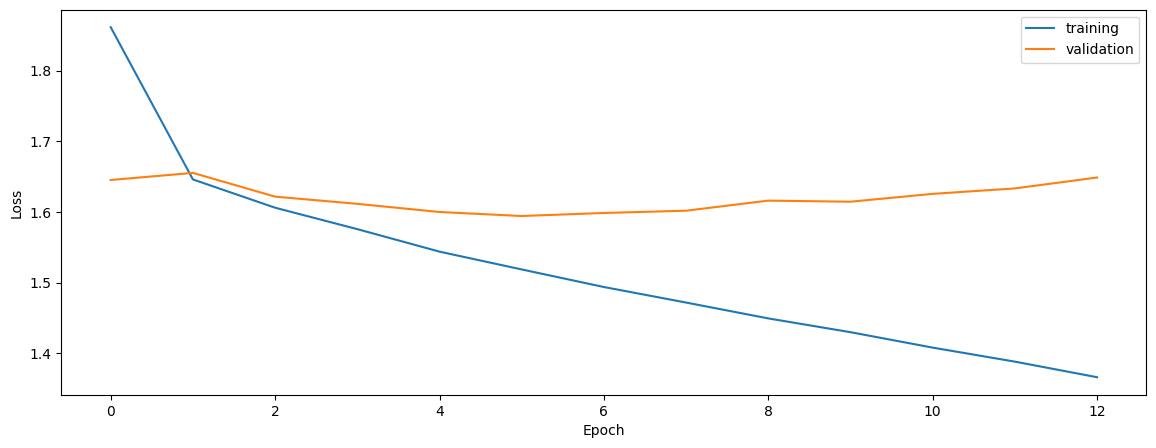

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.41110832249576
0.38442404768878247
0.40389513238926966


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

native
0.48185565442238953
0.4898477839931153
0.4739867370533572


In [9]:
print('normalized')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.47899279088395647
0.4803608757839146
0.47252226643926476


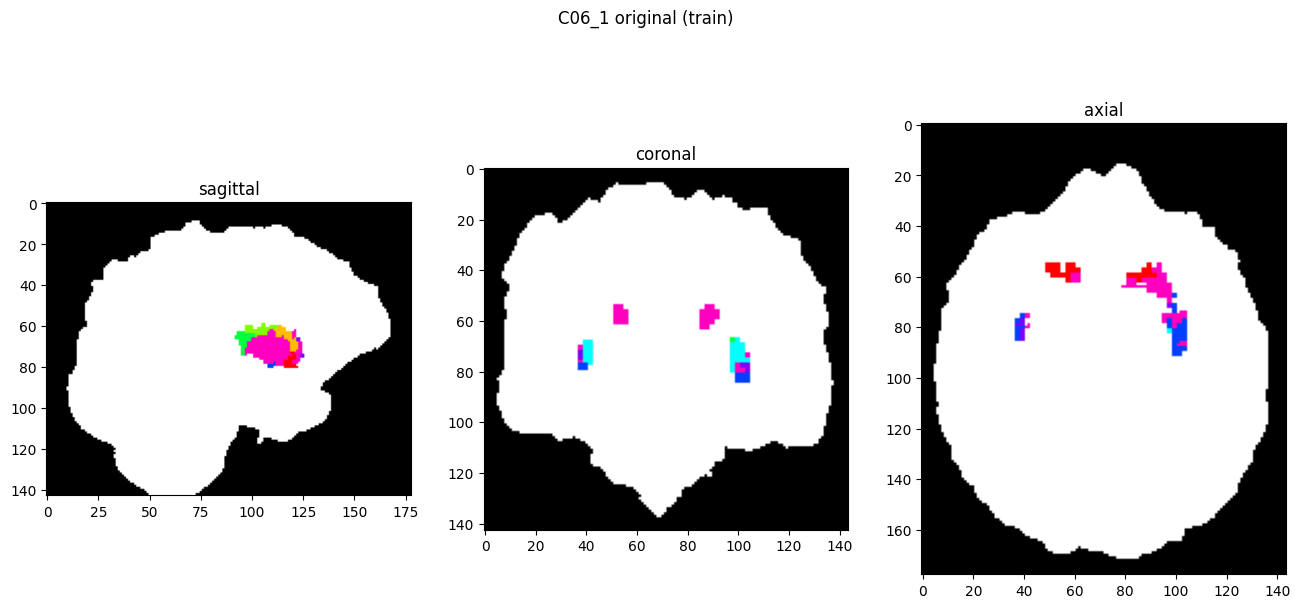

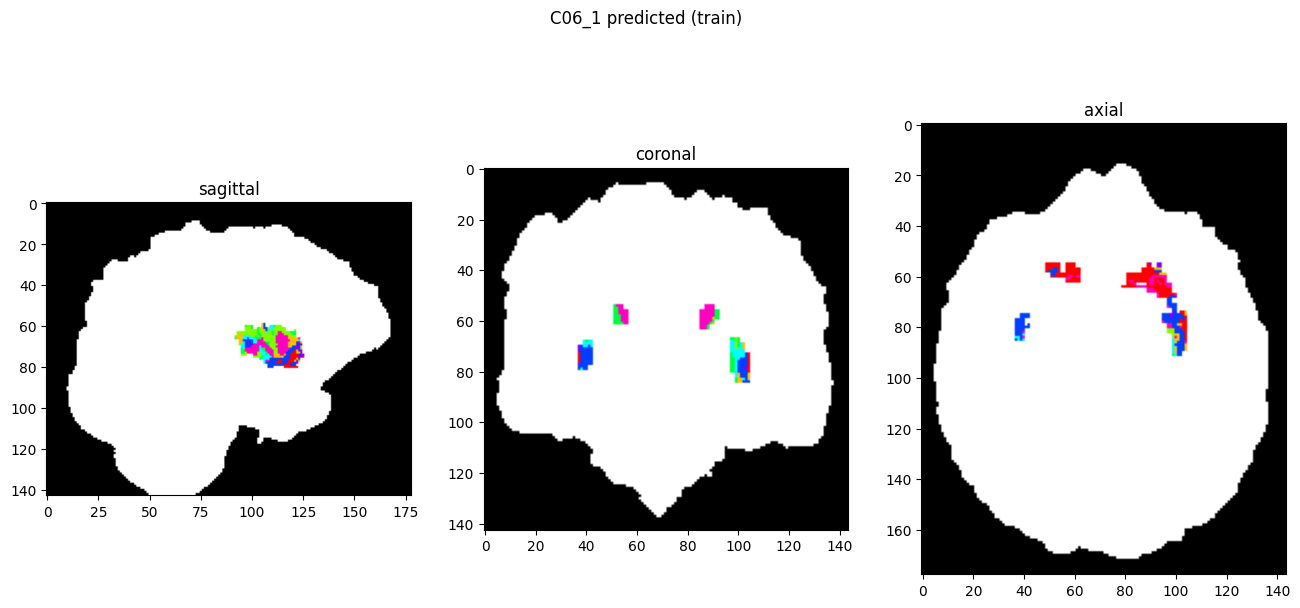

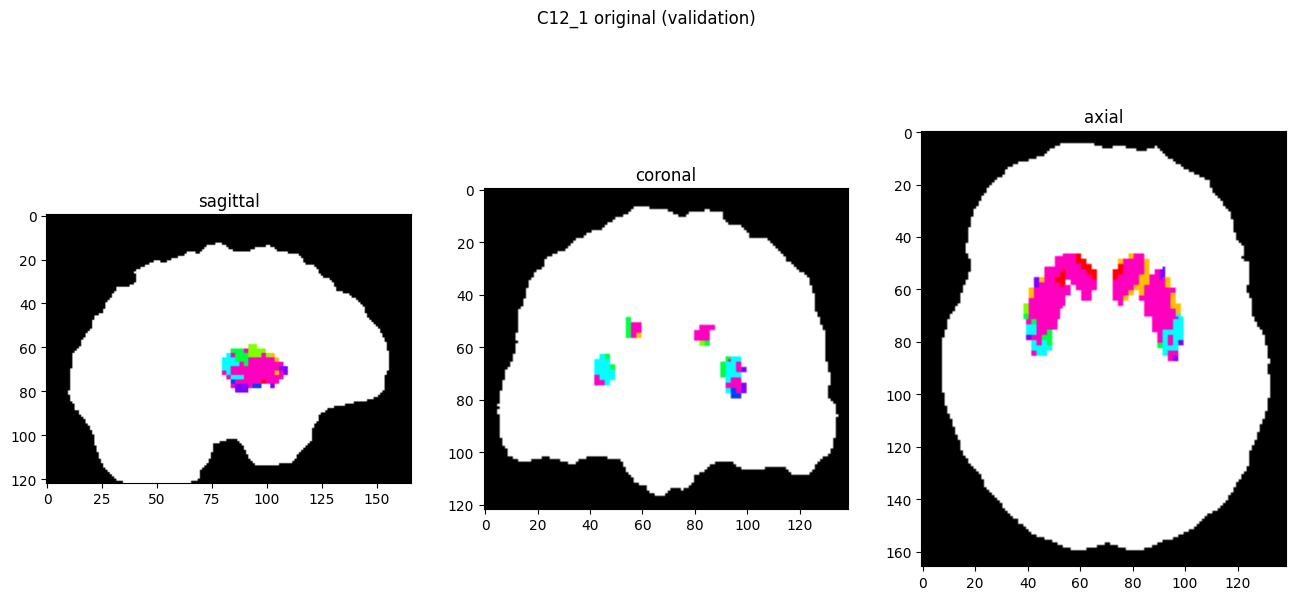

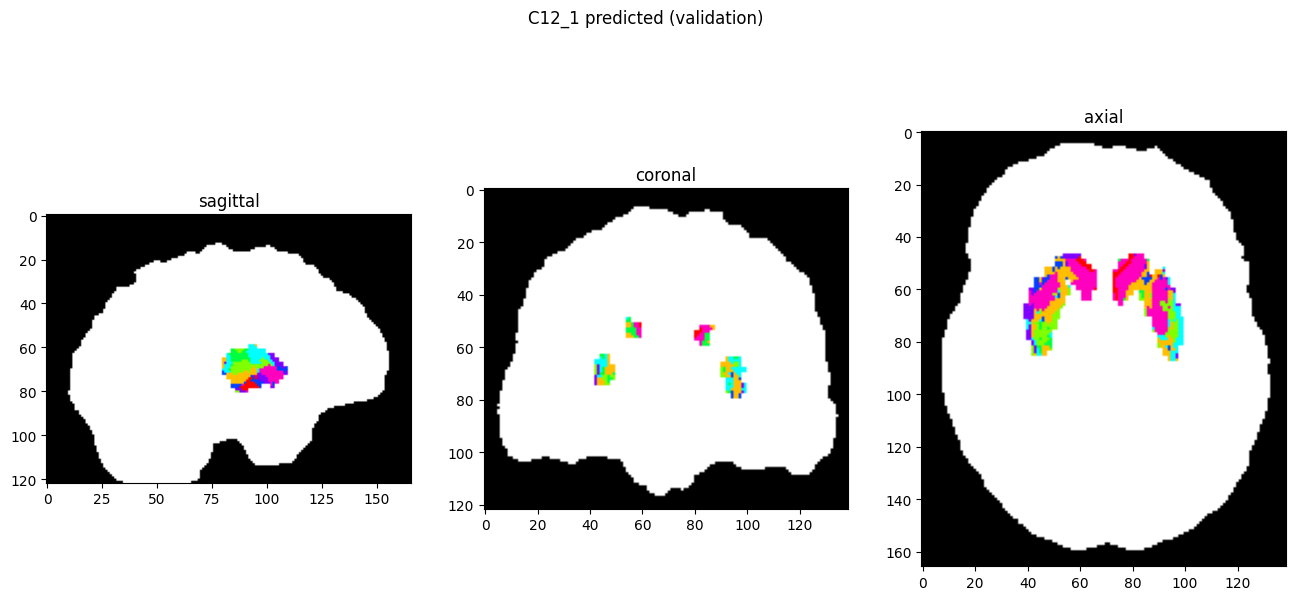

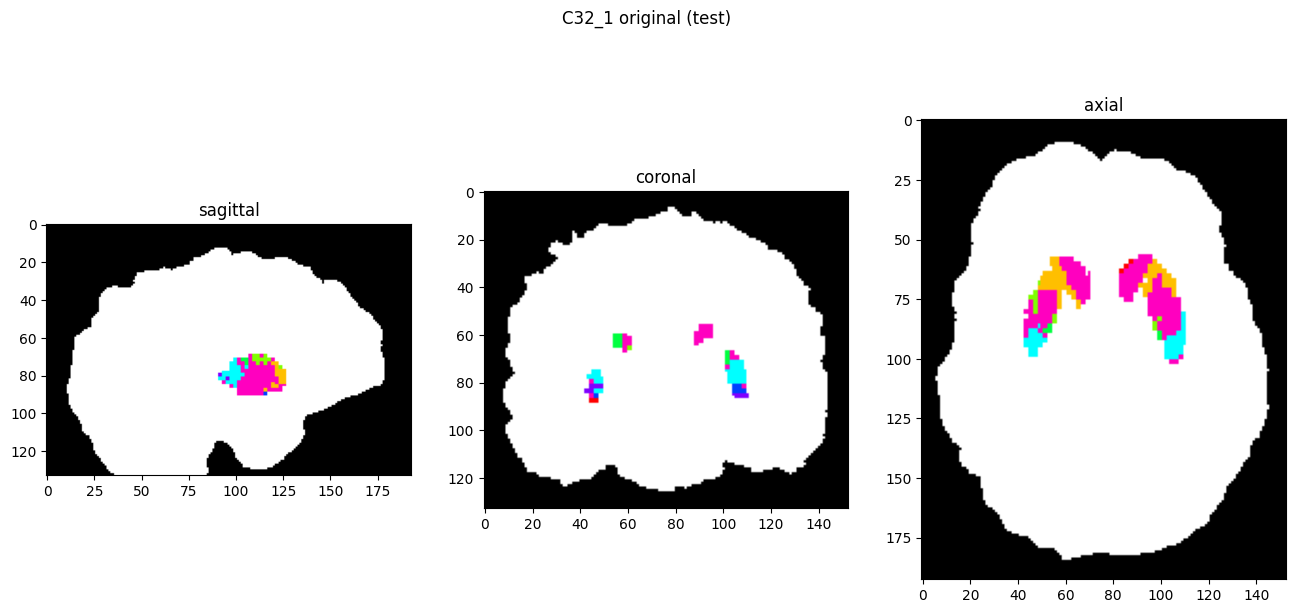

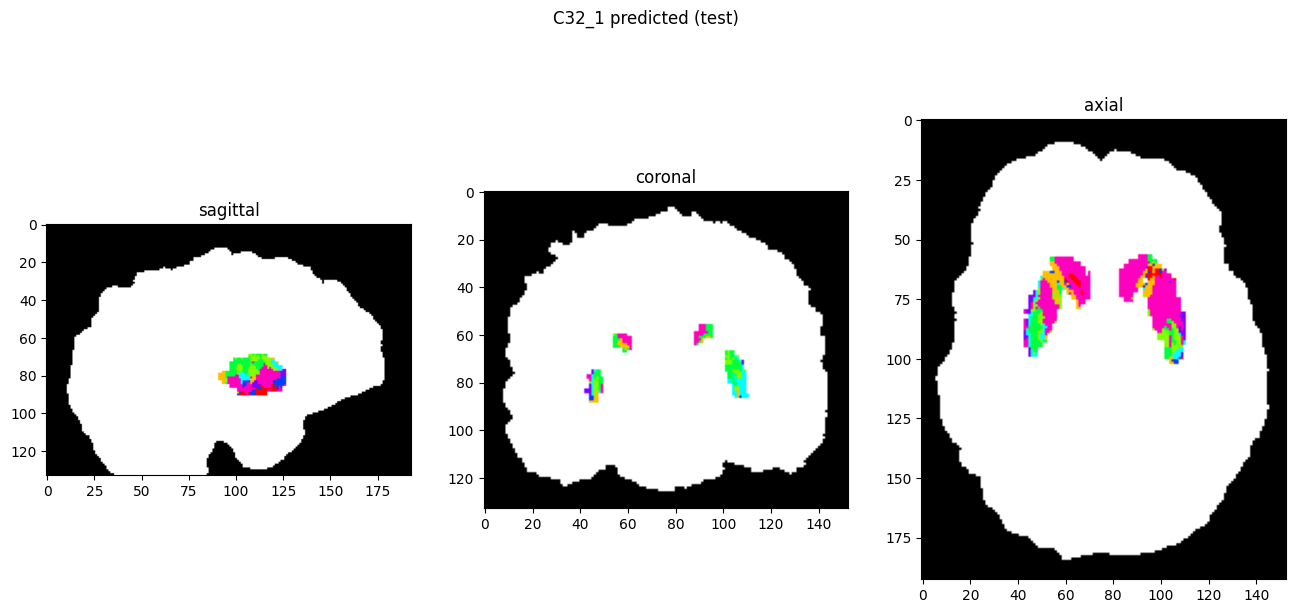

In [10]:
showResults(model, gen, threshold=0)